In [1]:
#import needed libraries (although not all imported below are used in the given code)

import os
from os import listdir
from os.path import isfile, join

import sys
import codecs
import fileinput
import string
from collections import OrderedDict

import numpy as np

from pandas import DataFrame
import pandas as pd

import matplotlib

%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.dates as md
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

#from mpl_toolkits.mplot3d import Axes3D
import scipy
from scipy import optimize, stats
from scipy.integrate import quad
from scipy.signal import find_peaks, peak_widths,hilbert

from decimal import Decimal



import iminuit 


import csv
import cmath
import math
from math import sqrt




# destination to the data (input) and output folders (change according to the path on your PC)

containing_folder_path = "/home/amslivar/work/AmBe_v2/AmBe_characterization_analysis/"
path_base = containing_folder_path + "2024_GeIII_calibration_Th228_with_attenuator/"
measurement_path= path_base +'Data/'
measurement_output_path= path_base + 'Results/'


#function to count number of significant digits after comma
def number_sigdigs(x):
    digs_after_comma = str(x - math.floor(x))
    digs_after_comma = digs_after_comma[2:]
    number=0
    for c in digs_after_comma:
        if c=='0':
            number+=1
        else:
            number+=2
            break
    return number

print('numpy version', np.__version__)
print('matplotlib version', matplotlib.__version__)
print('pandas version', pd.__version__)
print('scipy version', scipy.__version__)
print('iminuit version', iminuit.__version__)

numpy version 1.21.6
matplotlib version 3.5.3
pandas version 1.1.5
scipy version 1.7.3
iminuit version 2.18.0


In [2]:
# read the data files from measurement_path folder and replace "," delimiter with "."

files_in_folder = [f for f in listdir (measurement_path) if isfile(join(measurement_path, f))]
files_in_folder.sort()



In [3]:
# read the data files and put the content into list of dataframes

numbers=np.linspace(0,8191,num=8192)
numbers=list(numbers)

import re

scan = [] #list of measurement data (in DataFrame format) extracted from measurement files
files_scan=[] #list of measurement files

for f in files_in_folder:
    if "Th228_Cal_with_Att" in f: #choose only files with names containing "Th228Calibration_with_attenuator"
        
        print(f) #prints measurement file name
        files_scan.append(f) 
        


        scan_temp = pd.read_csv(measurement_path + f, #read file content in DataFrame format
            skiprows=(0,1),
            header=None,
            delimiter="\t",
            )
        print(scan_temp) #prints scan file data in DataFrame format
        
        scan.append(scan_temp) # add the dataframe to the list
        
for f in files_in_folder:        
    if "background" in f: #choose only files with names containing "Background"
        
        print(f) #prints scan file name
        files_scan.append(f) 


        scan_temp = pd.read_csv(measurement_path + f, #read file content in DataFrame format
            skiprows=(0,1),
            header=None,
            delimiter="\t",
            )
        print(scan_temp) #prints measurement file data in DataFrame format
        
        scan.append(scan_temp) # add the dataframe to the list

#Th-228 measurement time and background measurement time
t=422.68
t_bkg=64517.94  

#combine background data
bkg = np.asarray(scan[1][1])
i=2
while i <len(scan):
    bkg+=np.asarray(scan[i][1])
    i+=1
    
#rescale background data to Th-228 measurement time
bkg=bkg/t_bkg*t

#subtract rescaled background from Th-228 data
signal=np.asarray(scan[0][1])-bkg


Th228_Cal_with_Atten.dat
         0  1
0        0  0
1        1  0
2        2  0
3        3  0
4        4  0
...    ... ..
8187  8187  0
8188  8188  0
8189  8189  0
8190  8190  0
8191  8191  0

[8192 rows x 2 columns]
background_run_with_atten_04232024.dat
         0  1
0        0  0
1        1  0
2        2  0
3        3  0
4        4  0
...    ... ..
8187  8187  0
8188  8188  0
8189  8189  0
8190  8190  0
8191  8191  0

[8192 rows x 2 columns]


In [4]:
#checking that the measurement files have been read and written in the right order

i=0
while i<len(files_scan):
    print(i, files_scan[i])
    i+=1


0 Th228_Cal_with_Atten.dat
1 background_run_with_atten_04232024.dat


In [5]:
#list the Th-228 gamma peaks and their energies

Peak_name=["Pb-212", "208Tl","212Bi", "212Pb", "208Tl", "208Tl","212Bi", "208Tl","212Bi", "208Tl","212Bi","212Bi", "208Tl", "212Bi", "208Tl", "212Bi", "208Tl SE"]
Peak_energy=[115.183, 277.371, 288.2, 300.087, 510.69, 583.191, 727.33, 763.13, 785.37, 860.564, 893.408, 1078.62, 1093.9, 1512.7, 1592.511, 1620.5, 2103.511]
Peak_channel=[]
Peak_channel_err=[]
Sigma_channel=[]
Sigma_channel_err=[]

p=0

<ValueView A=175.56998210249856 sig=-2.652539653373315 mu=122.19698789324558 offset=251.83754436640524>
<ErrorView A=119.05197781435274 sig=1.4910138106746291 mu=1.7188020694640116 offset=7.464739582158434>
(175.56998210249856, -2.652539653373315, 122.19698789324558, 251.83754436640524)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71ce50c18> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:259: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71ce50c18> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

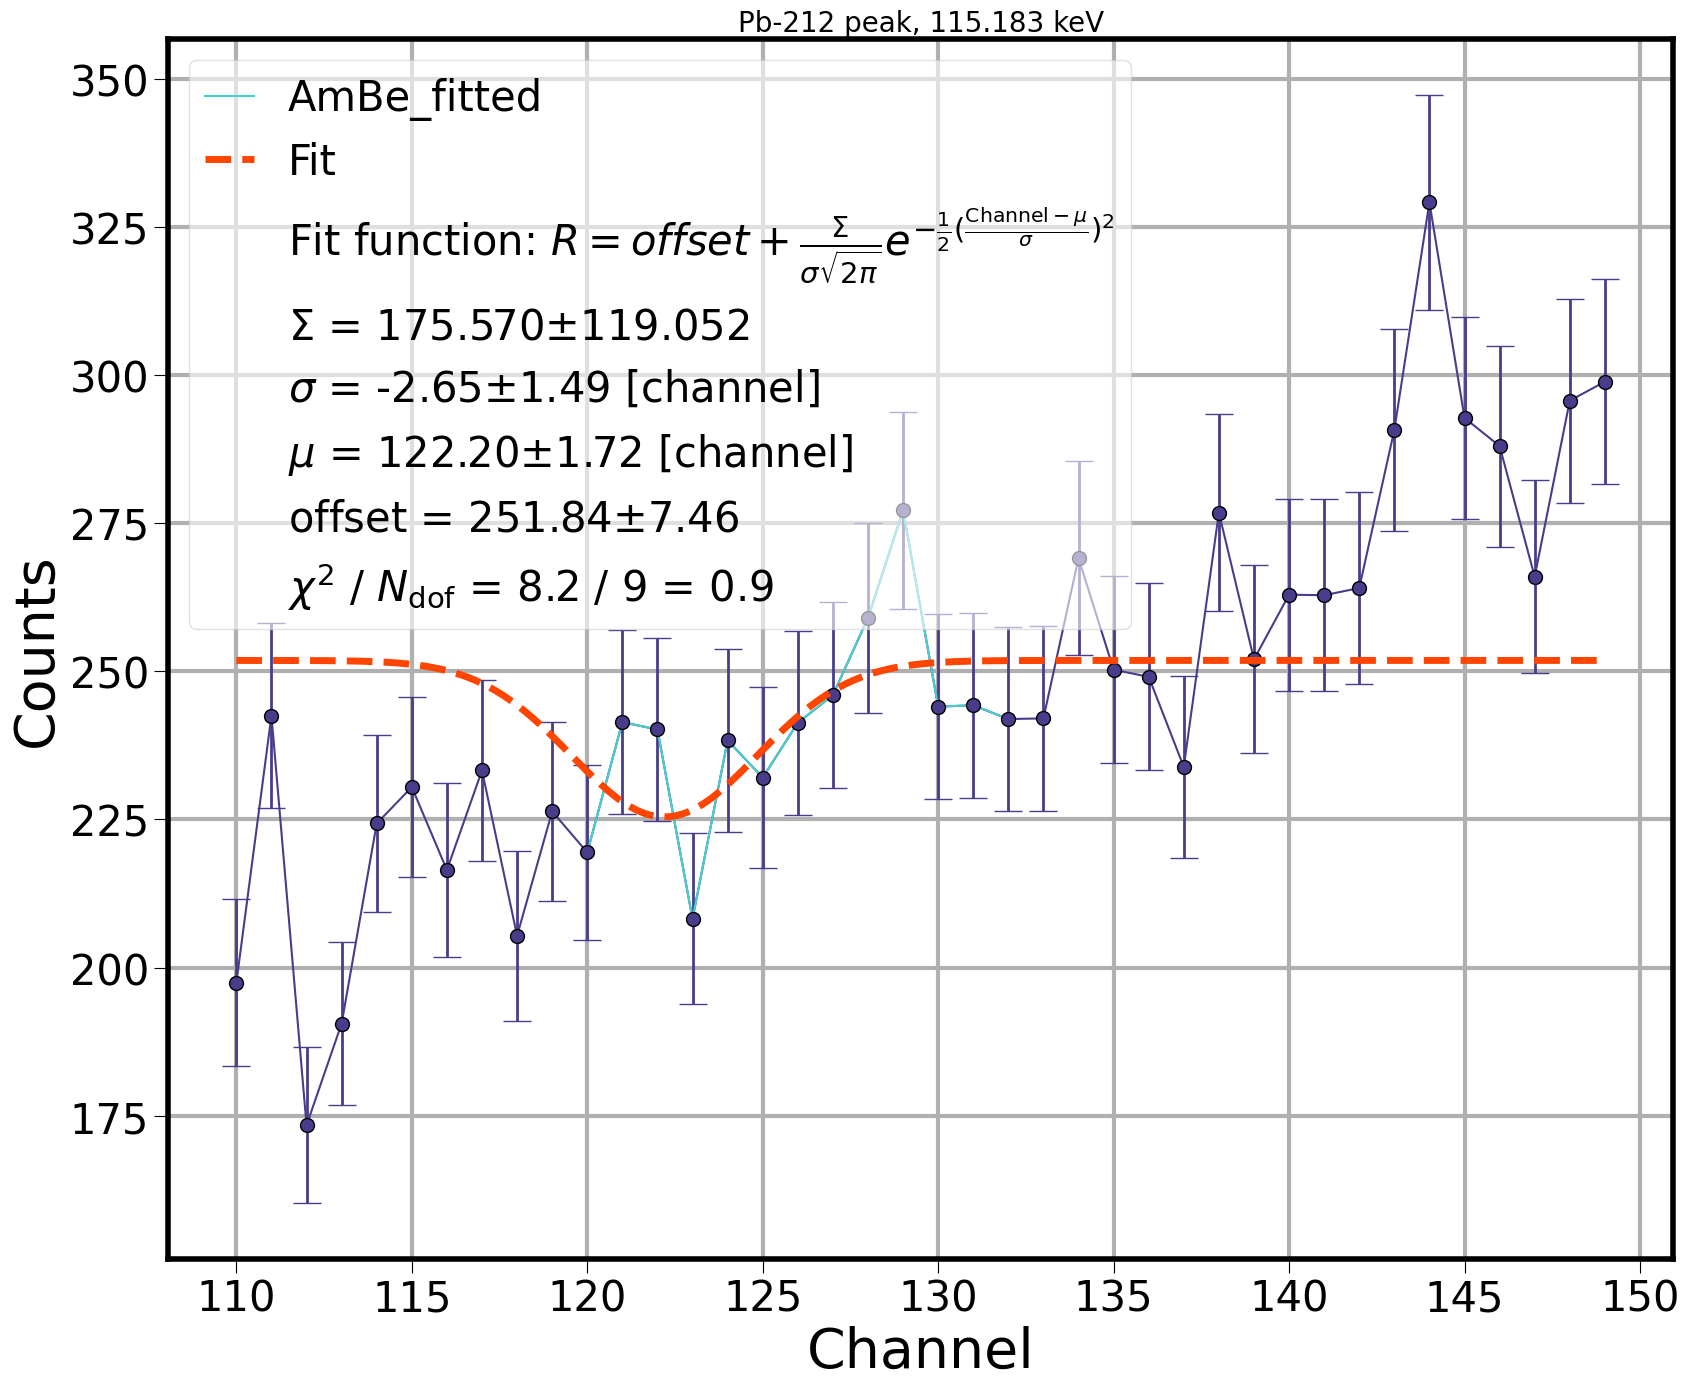

In [6]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()









ch1=120
ch2=133
ch3=110
ch4=150

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])



handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 500
mu00 = 127
sig00 = 5 
offset00 = 300

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl peak, 277.371 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 156.5 (chi2/ndof = 14.2)   │              Nfcn = 884              │
│ EDM = 0.00558 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           ABOVE call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │  -1.0e6   │   1.5e6   │            │            │         │         │       │
│ 1 │ sig    │    14     │     4     │            │            │         │         │       │
│ 2 │ mu     │    251    │    16     │            │            │         │         │       │
│ 3 │ offset │    130    │     5     │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────┐
│        │         A       sig        mu    offset │
├────────┼─────────────────────────────────────────┤
│      A │  2.28e+12 -3.04e+06  1.83e+07 -9.66e+05 │
│    sig │ -3.04e+06      13.7     -56.3      8.48 │
│     mu │  1.83e+07     -56.3       253     -29.6 │
│ offset │ -9.66e+05      8.48     -29.6      20.5 │
└────────┴─────────────────────────────────────────┘

<ValueView A=-980171.8308126766 sig=13.613948777962793 mu=251.338314554579 offset=130.32297554722365>
<ErrorView A=1509770.289477479 sig=3.697788095785093 mu=15.900959719055502 offset=4.5262129005964455>
(-980171.8308126766, 13.613948777962793, 251.338314554579, 130.32297554722365)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:216: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71b93d278> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:259: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71b93d278> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

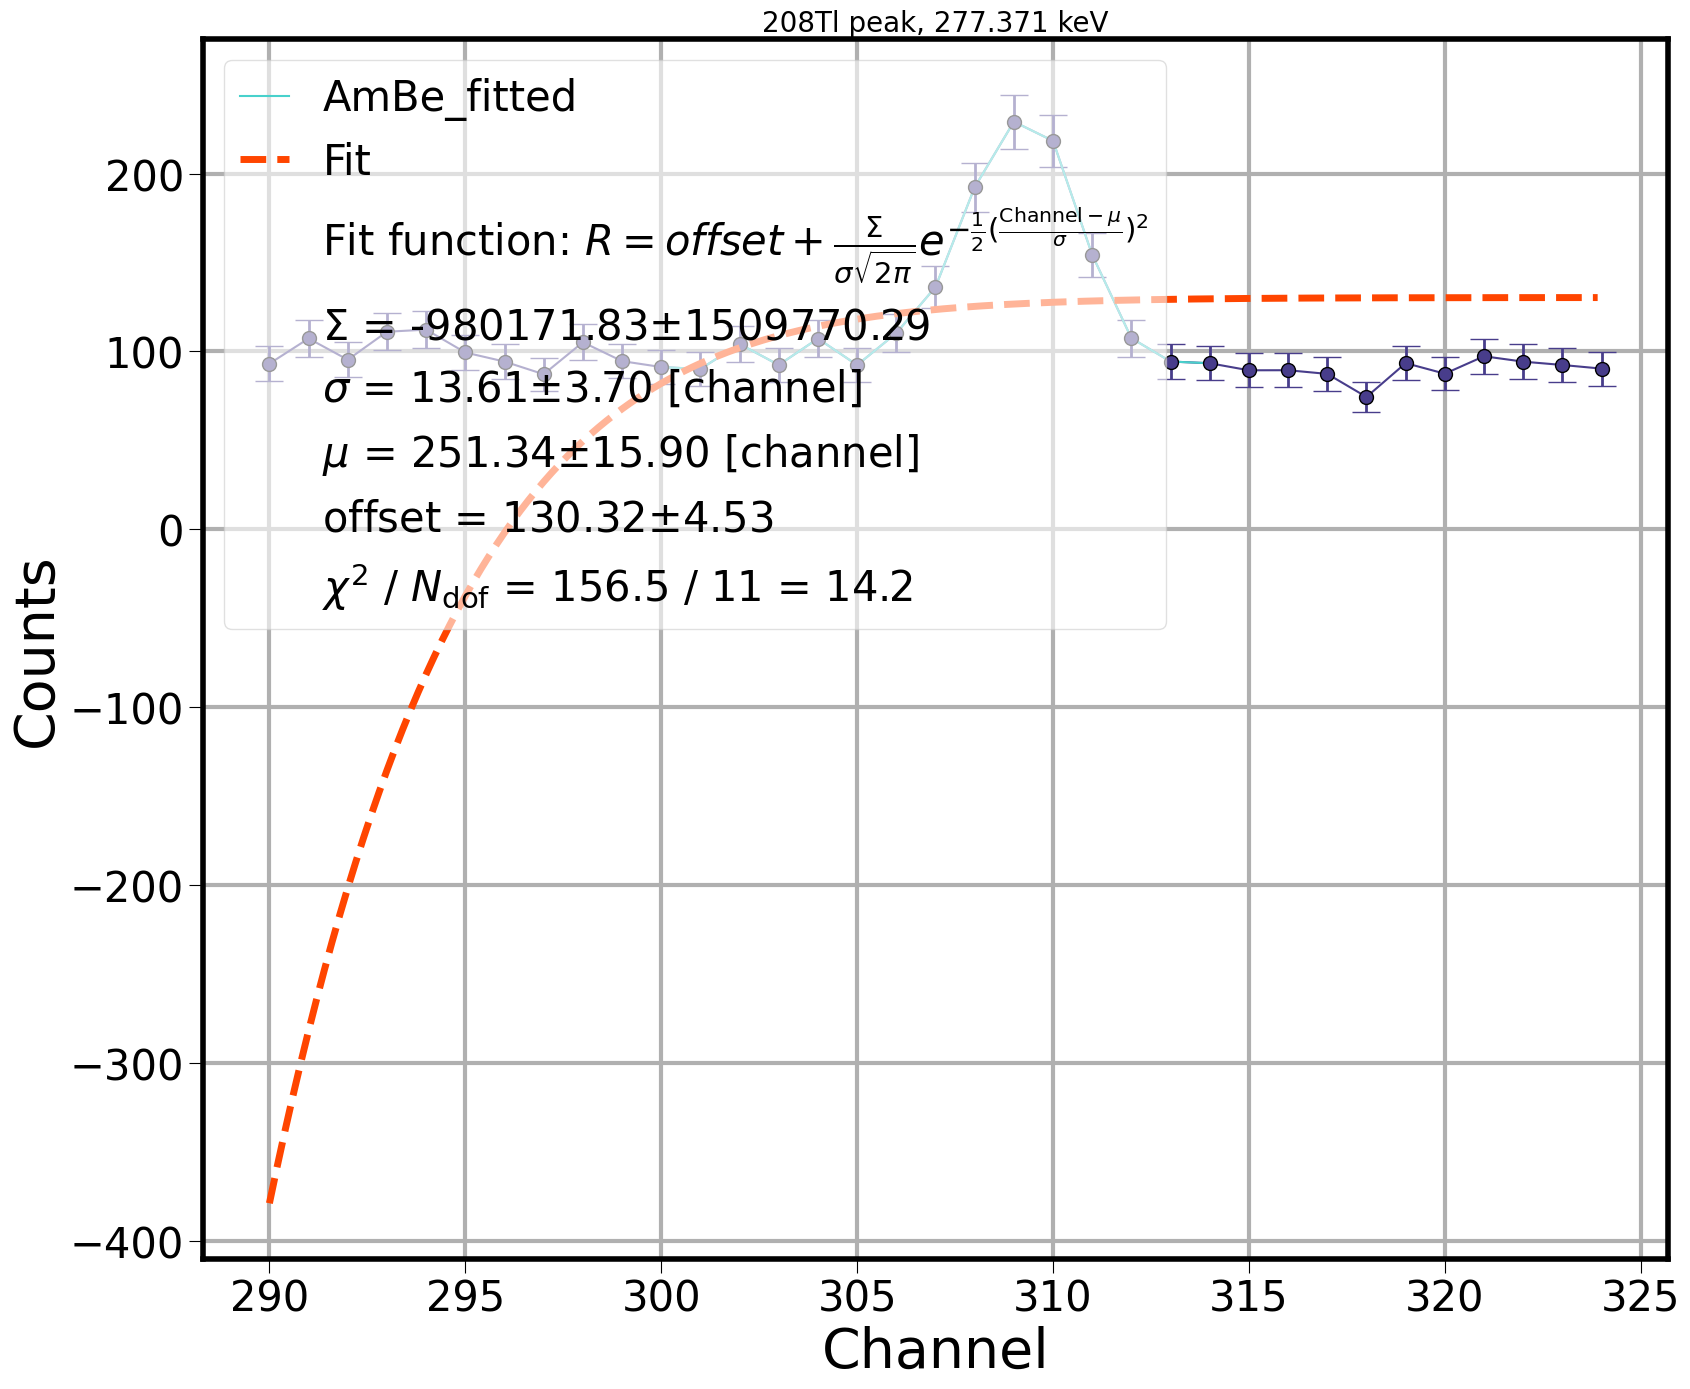

In [7]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()









ch1=300
ch2=315
ch3=290
ch4=325

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])



handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 1000
mu00 = 307
sig00 = 5 
offset00 = 160

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Bi peak, 288.2 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4.348 (chi2/ndof = 0.5)    │              Nfcn = 266              │
│ EDM = 0.000105 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    1e3    │    5e3    │            │            │         │         │       │
│ 1 │ sig    │    2.3    │    2.4    │            │            │         │         │       │
│ 2 │ mu     │    307    │     8     │            │            │         │         │       │
│ 3 │ offset │   89.2    │    3.0    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────┐
│        │         A       sig        mu    offset │
├────────┼─────────────────────────────────────────┤
│      A │  2.73e+07  4.69e+03 -3.67e+04  1.43e+03 │
│    sig │  4.69e+03      5.67     -14.7     -1.94 │
│     mu │ -3.67e+04     -14.7      64.2      1.17 │
│ offset │  1.43e+03     -1.94      1.17      9.33 │
└────────┴─────────────────────────────────────────┘

<ValueView A=999.9962034804878 sig=2.2971387657786186 mu=307.1036325375219 offset=89.2193765183017>
<ErrorView A=5222.69160120376 sig=2.3816506439408855 mu=8.01515323711091 offset=3.053771766892022>
(999.9962034804878, 2.2971387657786186, 307.1036325375219, 89.2193765183017)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:217: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71c1eae48> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:260: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71c1eae48> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

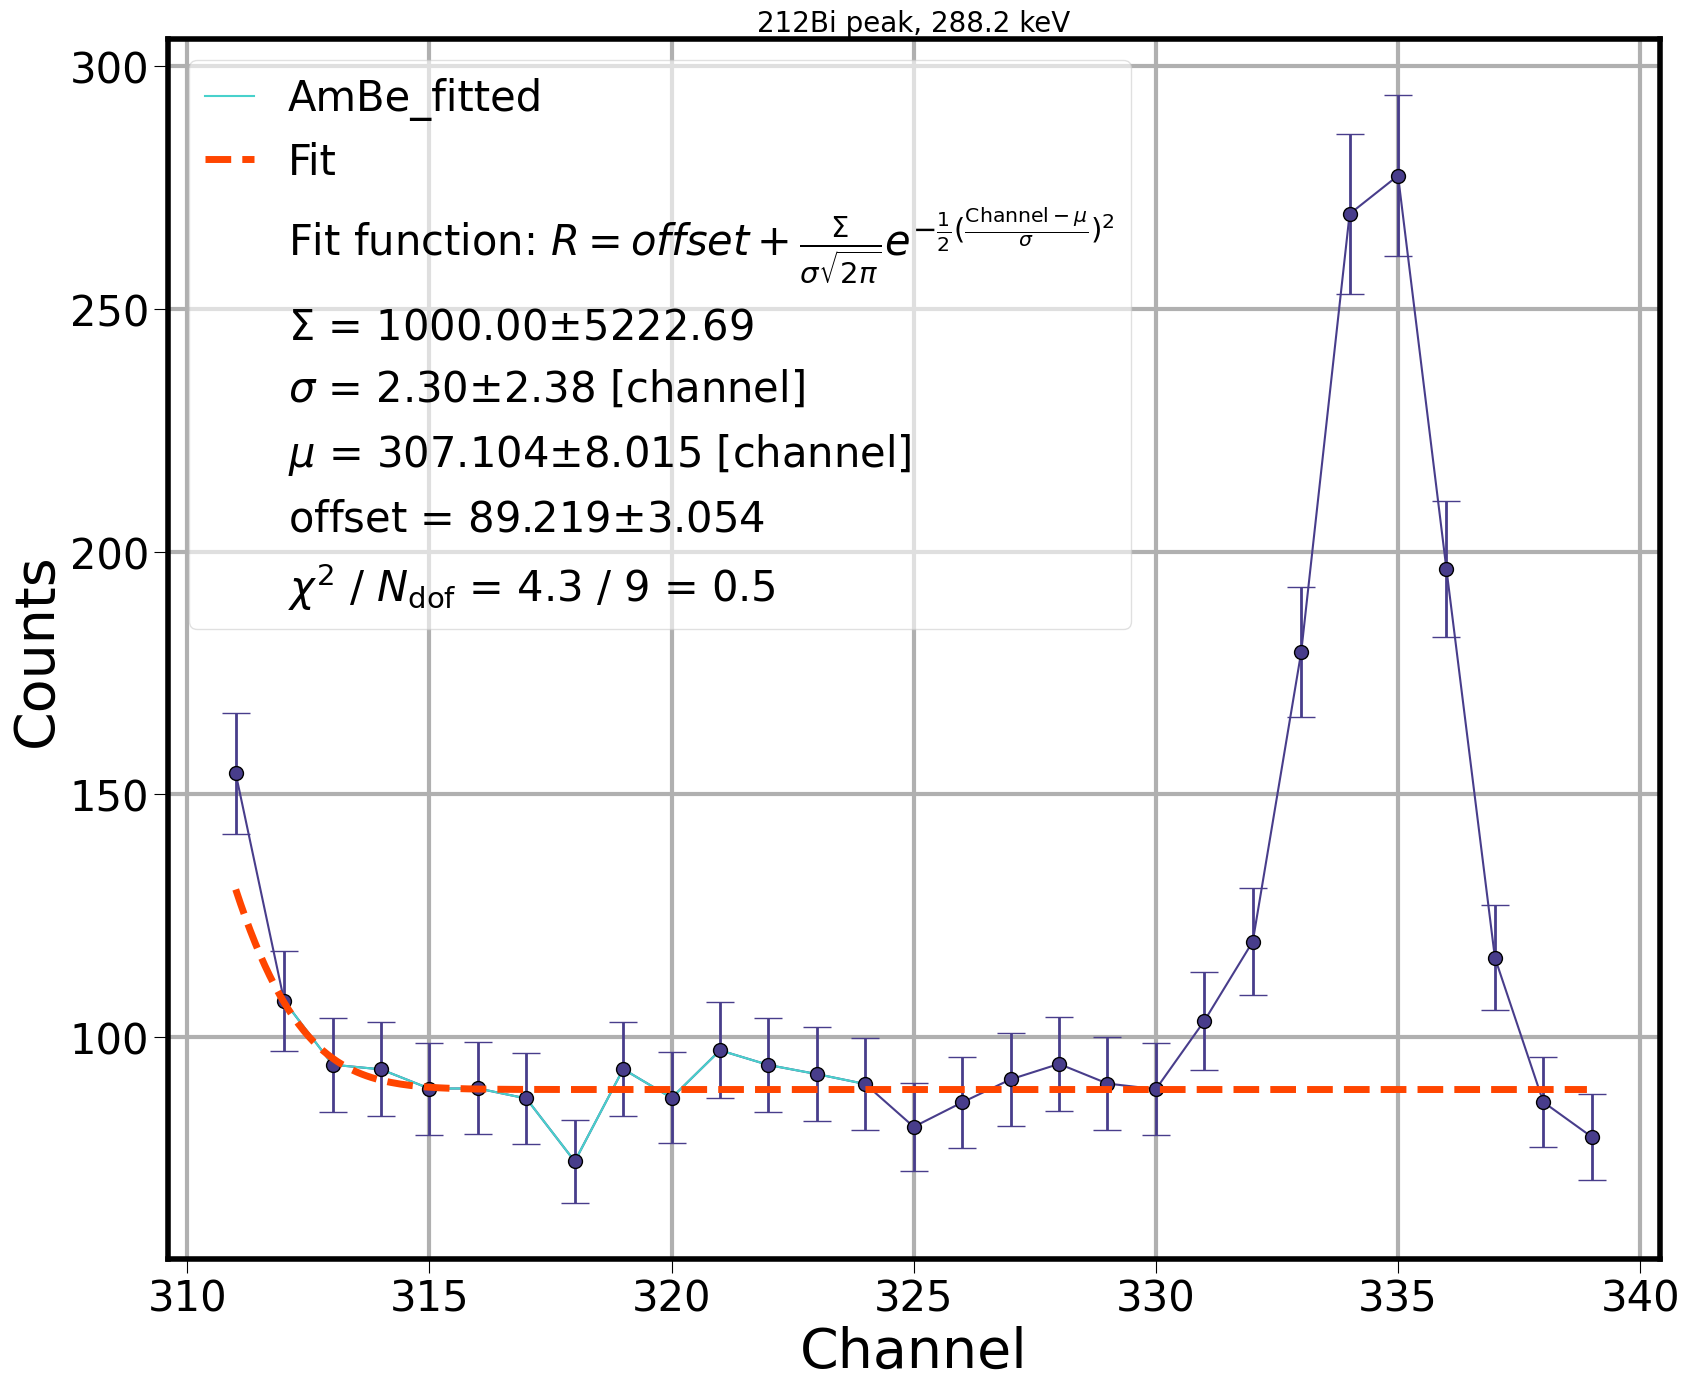

In [8]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()









ch1=312
ch2=325
ch3=311
ch4=340

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 1000
mu00 = 317
sig00 = 5 
offset00 = 160

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Pb peak, 300.087 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 294.3 (chi2/ndof = 26.8)   │              Nfcn = 884              │
│ EDM = 0.00149 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           ABOVE call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │  0.02e9   │  0.06e9   │            │            │         │         │       │
│ 1 │ sig    │   -3.9    │    1.2    │            │            │         │         │       │
│ 2 │ mu     │    357    │     7     │            │            │         │         │       │
│ 3 │ offset │   114.9   │    2.8    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────┐
│        │        A      sig       mu   offset │
├────────┼─────────────────────────────────────┤
│      A │ 3.97e+15 -3.4e+07 3.27e+08 1.01e+07 │
│    sig │ -3.4e+07     1.35     -7.5   -0.208 │
│     mu │ 3.27e+08     -7.5     47.9     0.65 │
│ offset │ 1.01e+07   -0.208     0.65     7.96 │
└────────┴─────────────────────────────────────┘

<ValueView A=16752417.99913964 sig=-3.9388538798026373 mu=357.2157698125687 offset=114.88259932295472>
<ErrorView A=62987435.95367503 sig=1.1612672288603265 mu=6.9229677885188865 offset=2.820948116520324>
(16752417.99913964, -3.9388538798026373, 357.2157698125687, 114.88259932295472)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:217: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71c1f6b00> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:260: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71c1f6b00> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

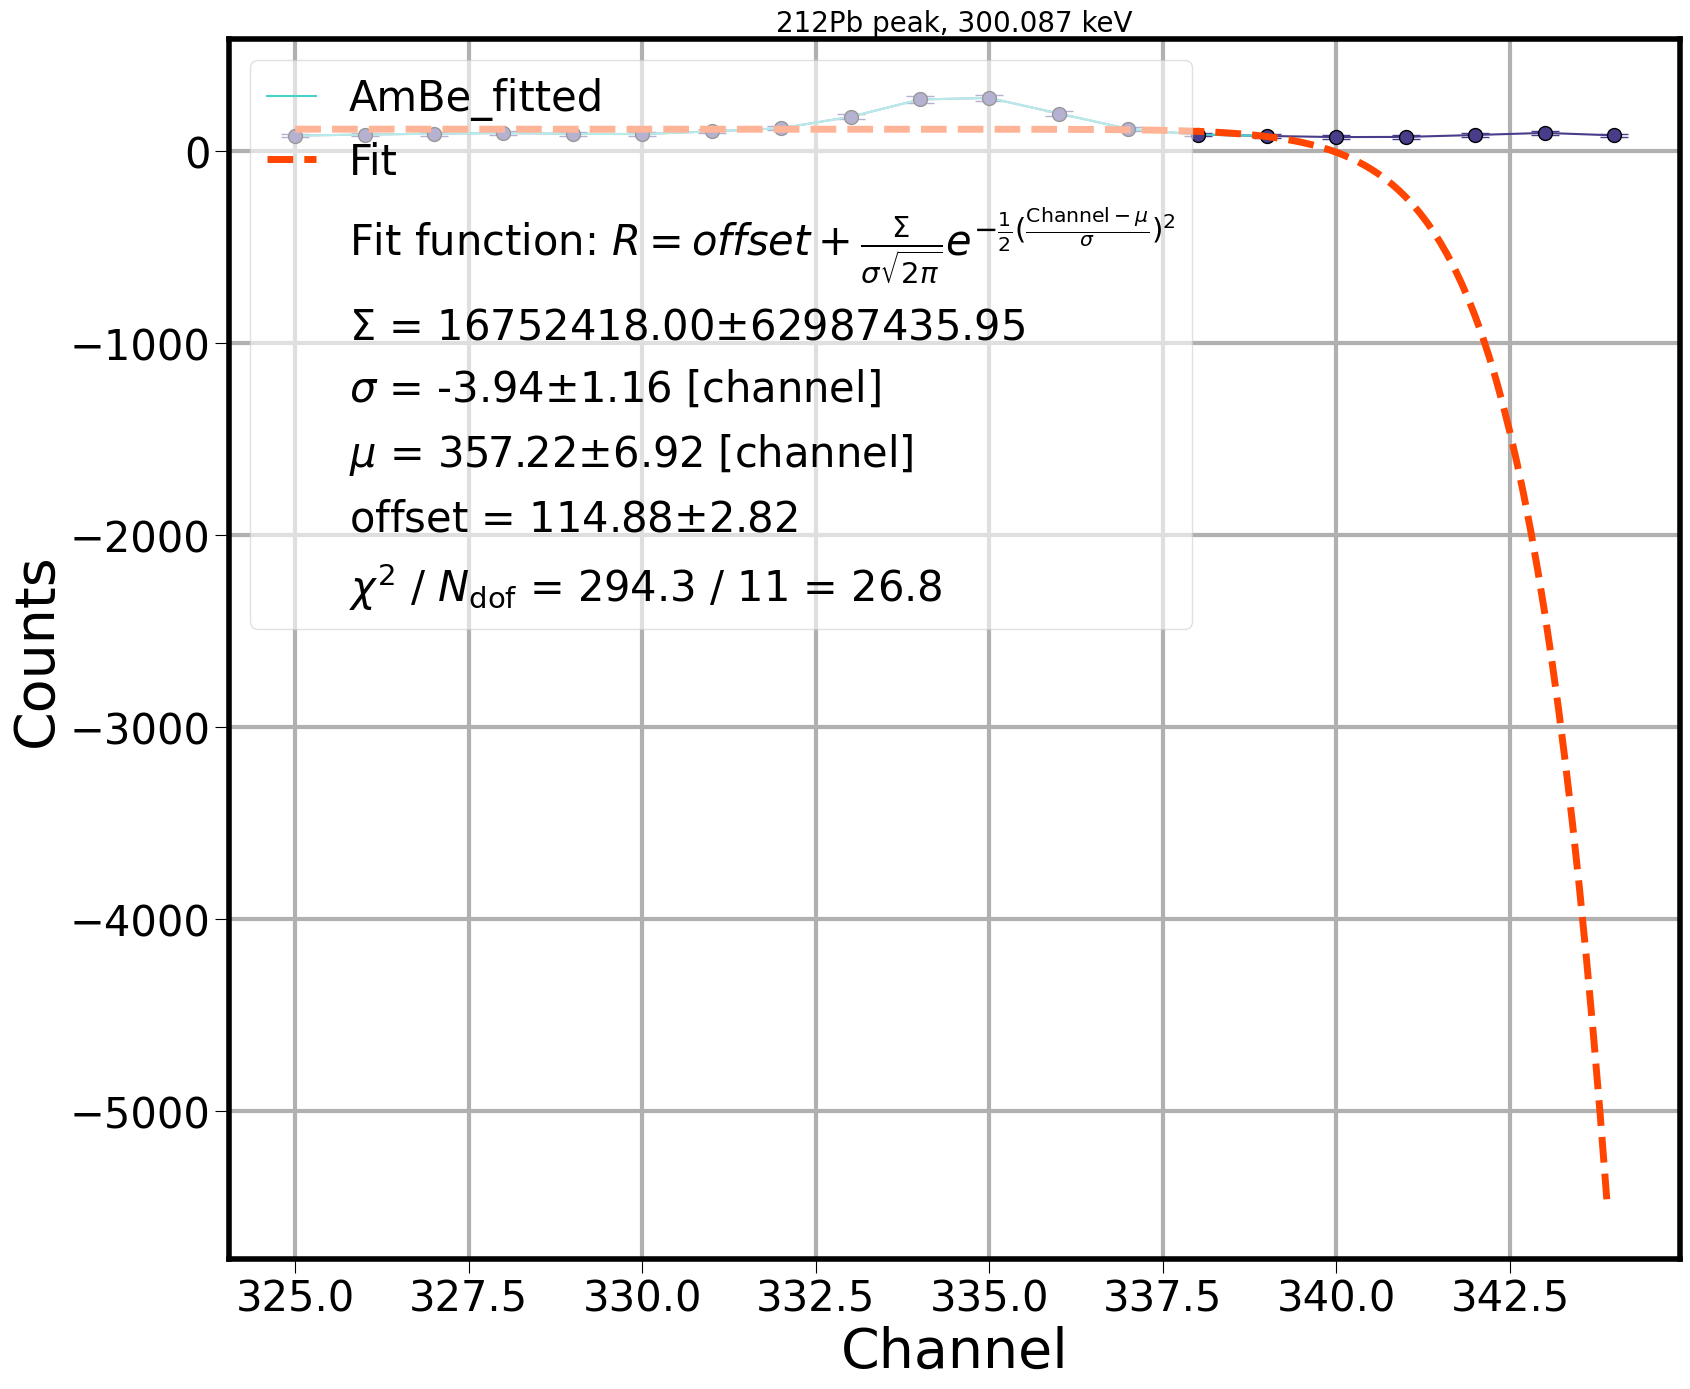

In [9]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()










ch1=325
ch2=340
ch3=325
ch4=345

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])



handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 1000
mu00 = 332
sig00 = 5 
offset00 = 160

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl peak, 510.69 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 171.3 (chi2/ndof = 1.8)    │              Nfcn = 191              │
│ EDM = 1.72e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │  -1.75e3  │  0.05e3   │            │            │         │         │       │
│ 1 │ sig    │   -1.60   │   0.04    │            │            │         │         │       │
│ 2 │ mu     │  568.66   │   0.04    │            │            │         │         │       │
│ 3 │ offset │   26.7    │    0.5    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────┐
│        │         A       sig        mu    offset │
├────────┼─────────────────────────────────────────┤
│      A │  2.03e+03     0.261  -0.00443      2.81 │
│    sig │     0.261   0.00139 -3.88e-07    0.0026 │
│     mu │  -0.00443 -3.88e-07   0.00194 -4.56e-05 │
│ offset │      2.81    0.0026 -4.56e-05     0.296 │
└────────┴─────────────────────────────────────────┘

<ValueView A=-1753.0289638324512 sig=-1.5962612521769095 mu=568.6589536566437 offset=26.746142790323706>
<ErrorView A=45.096413621088765 sig=0.037219960291575864 mu=0.04399228787506885 offset=0.5436118420111199>
(-1753.0289638324512, -1.5962612521769095, 568.6589536566437, 26.746142790323706)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:218: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71c4df710> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:261: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71c4df710> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

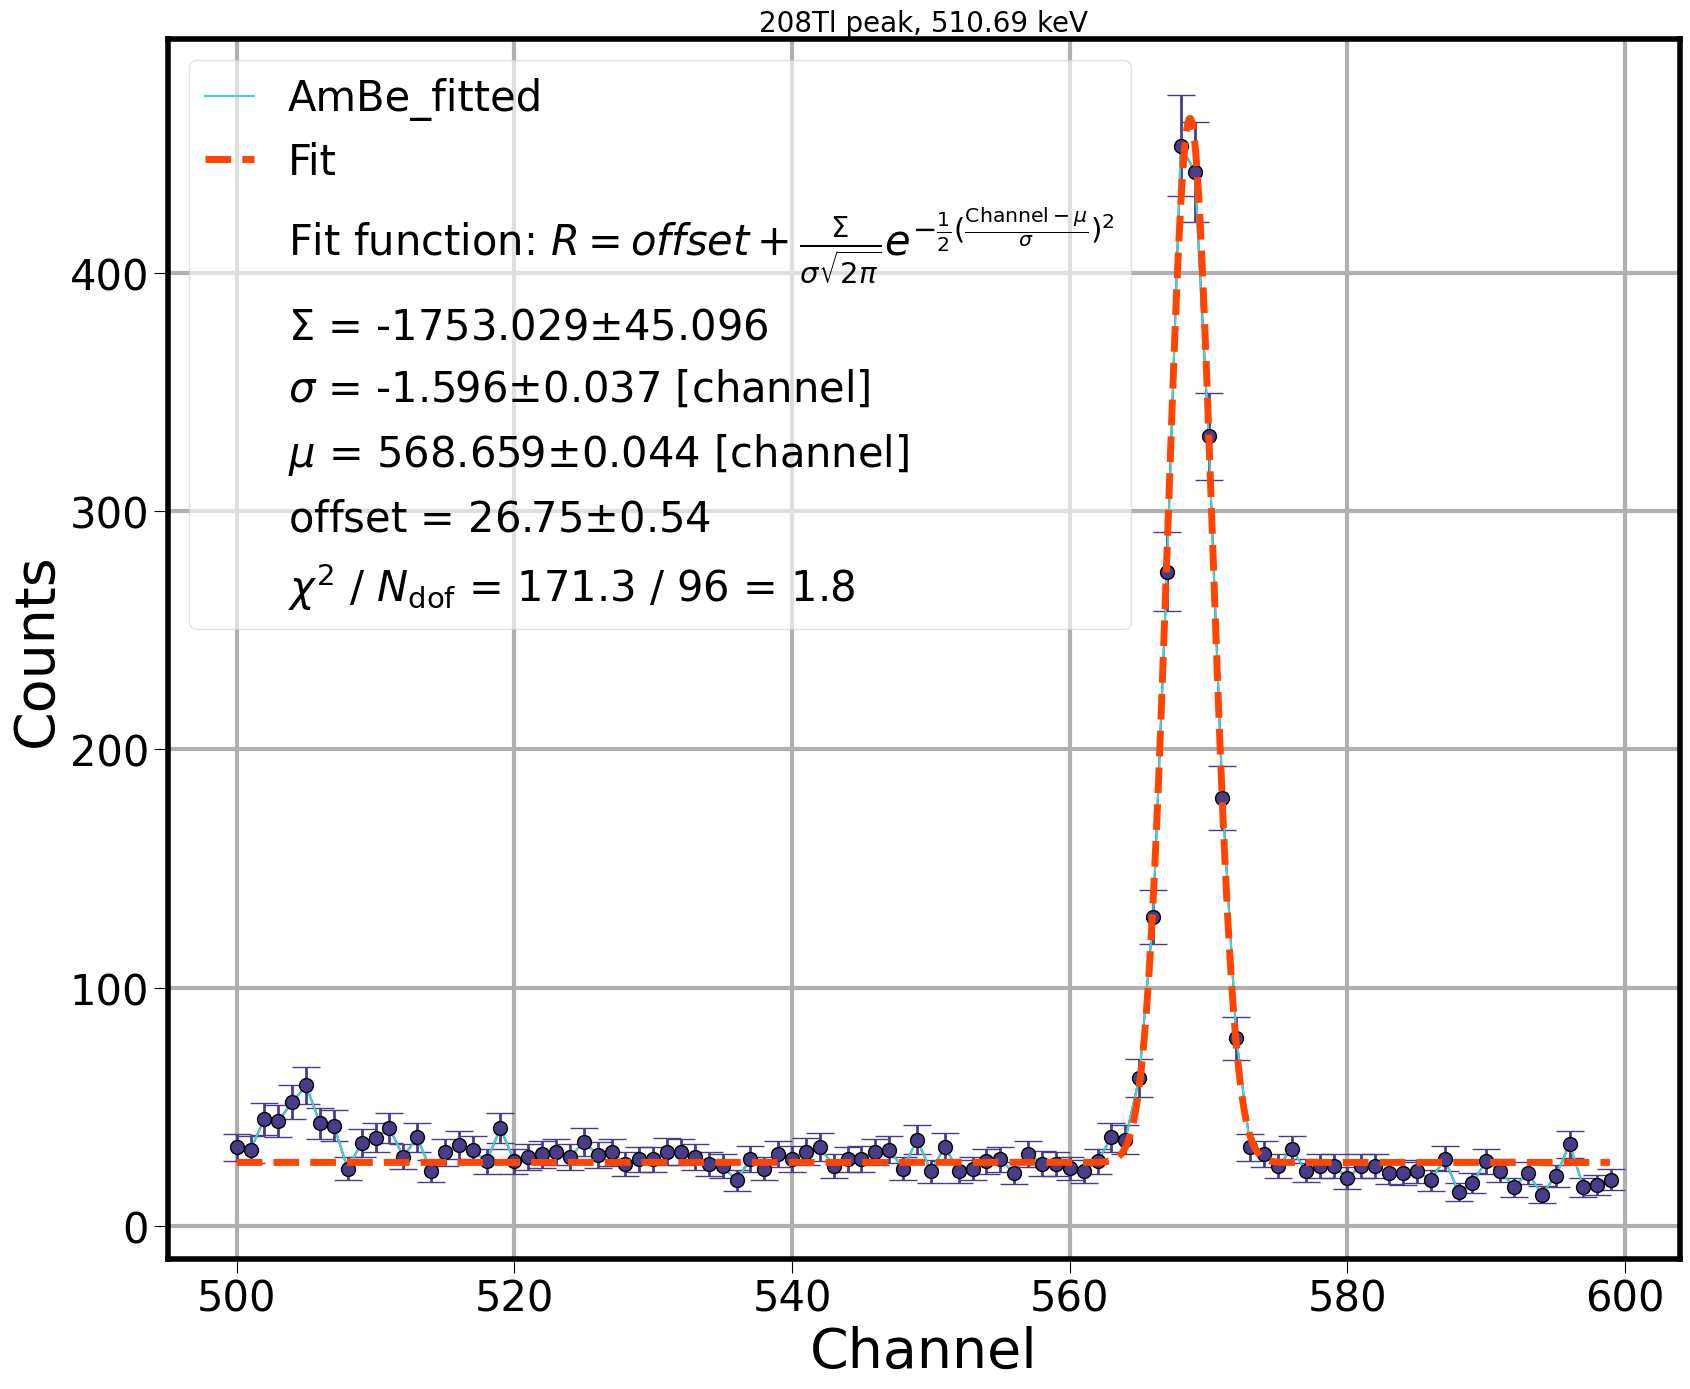

In [10]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()










ch1=500
ch2=600
ch3=500
ch4=600

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 1000
mu00 = 565
sig00 = 5 
offset00 = 160

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl peak, 583.191 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 229.5 (chi2/ndof = 2.4)    │              Nfcn = 298              │
│ EDM = 1.32e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │  4.95e3   │  0.07e3   │            │            │         │         │       │
│ 1 │ sig    │   1.463   │   0.017   │            │            │         │         │       │
│ 2 │ mu     │  649.212  │   0.022   │            │            │         │         │       │
│ 3 │ offset │   14.7    │    0.4    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────┐
│        │         A       sig        mu    offset │
├────────┼─────────────────────────────────────────┤
│      A │   5.1e+03    0.0615   0.00188     -1.54 │
│    sig │    0.0615  0.000287  1.31e-05 -0.000617 │
│     mu │   0.00188  1.31e-05  0.000472 -2.21e-05 │
│ offset │     -1.54 -0.000617 -2.21e-05     0.162 │
└────────┴─────────────────────────────────────────┘

<ValueView A=4948.923610829452 sig=1.463061283020311 mu=649.2121659796845 offset=14.652793256672425>
<ErrorView A=71.43329736796049 sig=0.016940514665418953 mu=0.02171729668924354 offset=0.4023866538956638>
(4948.923610829452, 1.463061283020311, 649.2121659796845, 14.652793256672425)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:218: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71c177da0> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:261: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71c177da0> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

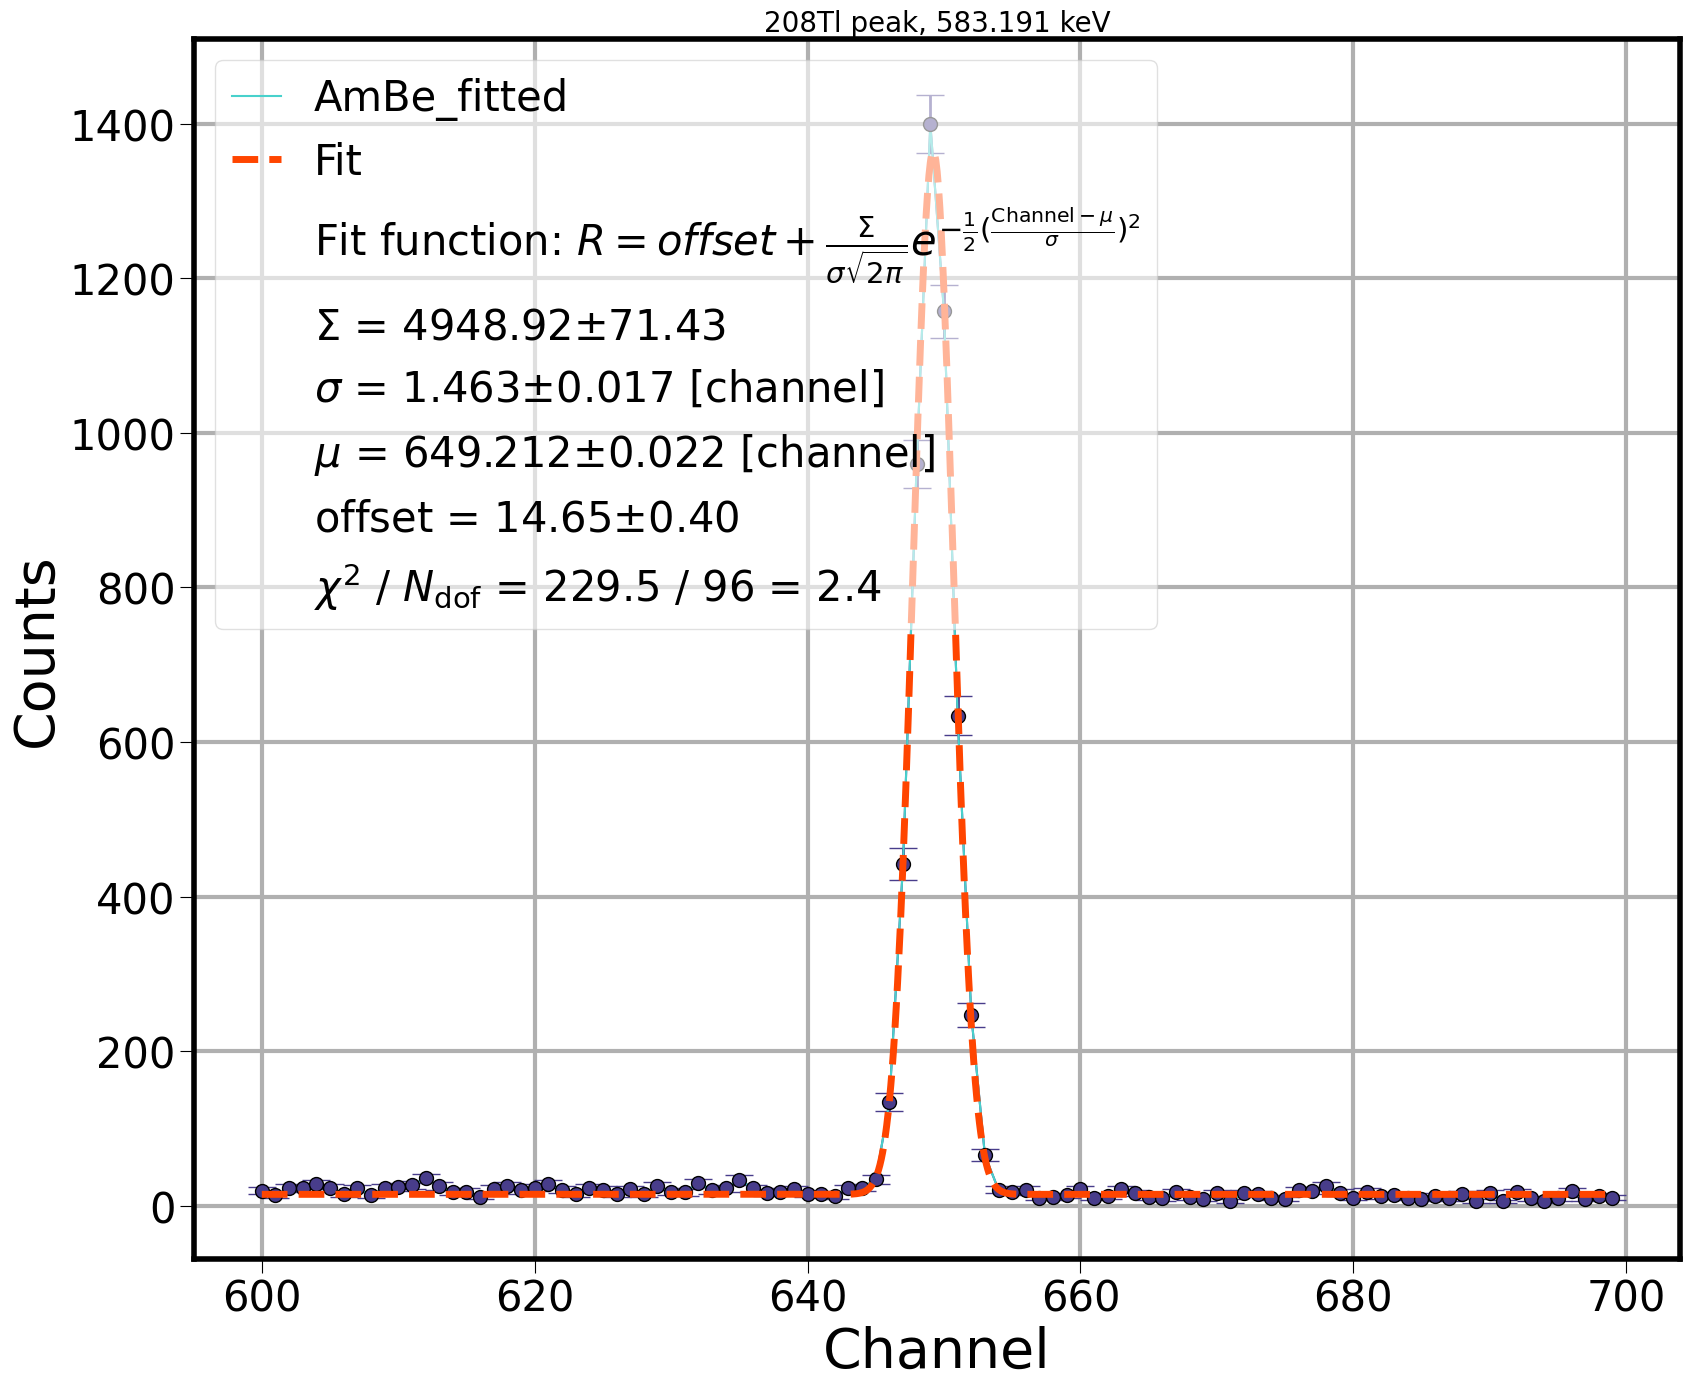

In [11]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()










ch1=600
ch2=700
ch3=600
ch4=700

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 1000
mu00 = 645
sig00 = 5 
offset00 = 100

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Bi peak, 727.33 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 53.7 (chi2/ndof = 1.2)     │              Nfcn = 169              │
│ EDM = 1.14e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    953    │    32     │            │            │         │         │       │
│ 1 │ sig    │   1.47    │   0.04    │            │            │         │         │       │
│ 2 │ mu     │  809.41   │   0.05    │            │            │         │         │       │
│ 3 │ offset │    7.5    │    0.4    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────┐
│        │         A       sig        mu    offset │
├────────┼─────────────────────────────────────────┤
│      A │  1.03e+03     0.144   0.00726      -1.6 │
│    sig │     0.144   0.00195   8.8e-05  -0.00289 │
│     mu │   0.00726   8.8e-05   0.00265 -0.000148 │
│ offset │      -1.6  -0.00289 -0.000148     0.181 │
└────────┴─────────────────────────────────────────┘

<ValueView A=953.4807936670691 sig=1.4675153323919237 mu=809.4105537571161 offset=7.458183150799678>
<ErrorView A=32.14582336863824 sig=0.04420542891534056 mu=0.05152502224742076 offset=0.42561704196486866>
(953.4807936670691, 1.4675153323919237, 809.4105537571161, 7.458183150799678)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:217: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71eebebe0> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:260: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71eebebe0> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

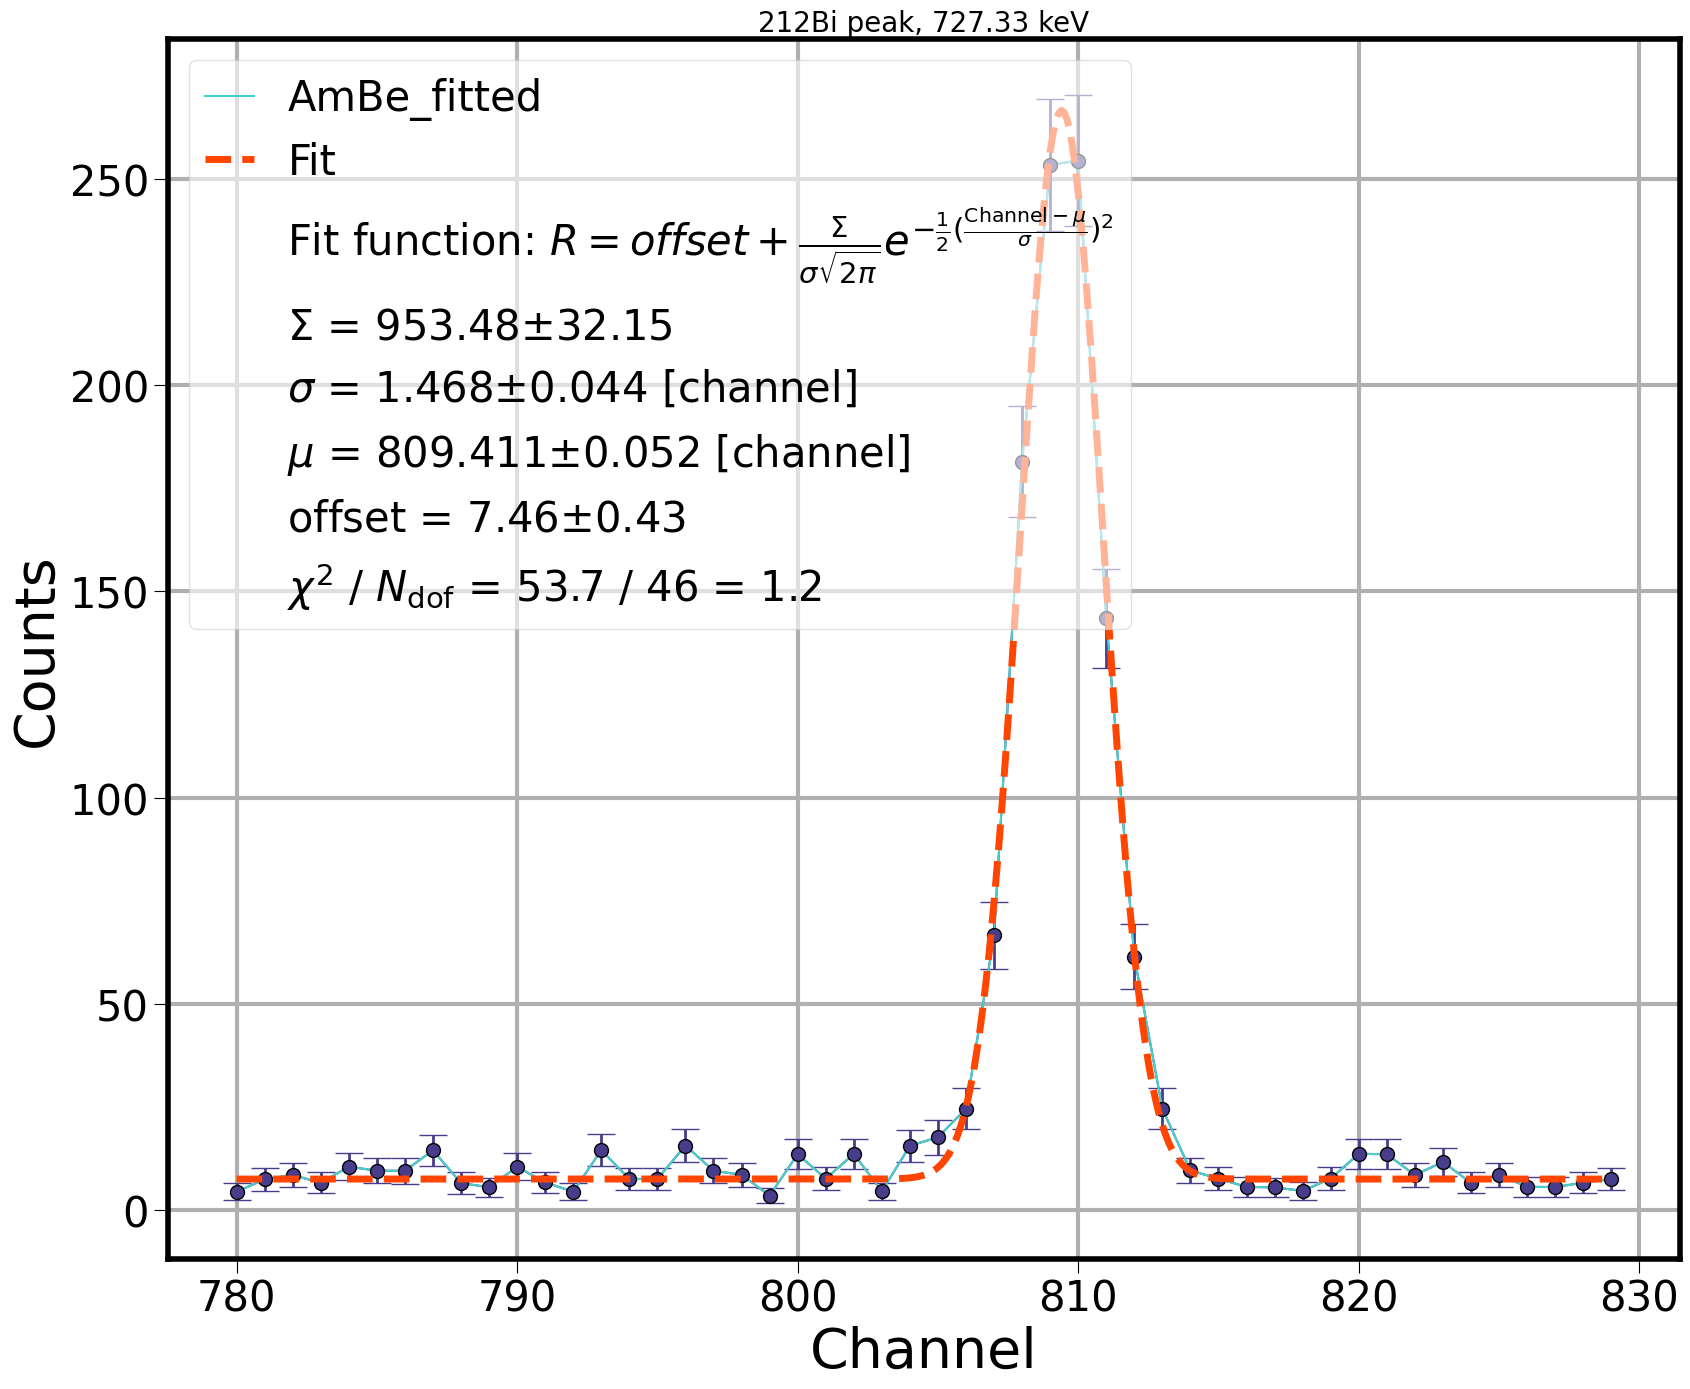

In [12]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()










ch1=780
ch2=830
ch3=780
ch4=830

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])



handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 1000
mu00 = 805
sig00 = 2 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl peak, 763.13 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 26 (chi2/ndof = 1.0)       │              Nfcn = 113              │
│ EDM = 9.68e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    93     │    13     │            │            │         │         │       │
│ 1 │ sig    │   1.46    │   0.20    │            │            │         │         │       │
│ 2 │ mu     │  849.68   │   0.23    │            │            │         │         │       │
│ 3 │ offset │    5.9    │    0.5    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────┐
│        │       A     sig      mu  offset │
├────────┼─────────────────────────────────┤
│      A │     160   0.895  -0.311   -2.25 │
│    sig │   0.895  0.0402 -0.0181 -0.0298 │
│     mu │  -0.311 -0.0181  0.0535  0.0103 │
│ offset │   -2.25 -0.0298  0.0103   0.272 │
└────────┴─────────────────────────────────┘

<ValueView A=92.95537586074643 sig=1.462496696827779 mu=849.6769199139494 offset=5.896809397987871>
<ErrorView A=12.667044085628326 sig=0.2004380219804049 mu=0.23131581712123678 offset=0.5210706642864693>
(92.95537586074643, 1.462496696827779, 849.6769199139494, 5.896809397987871)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:217: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71af73748> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:260: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71af73748> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

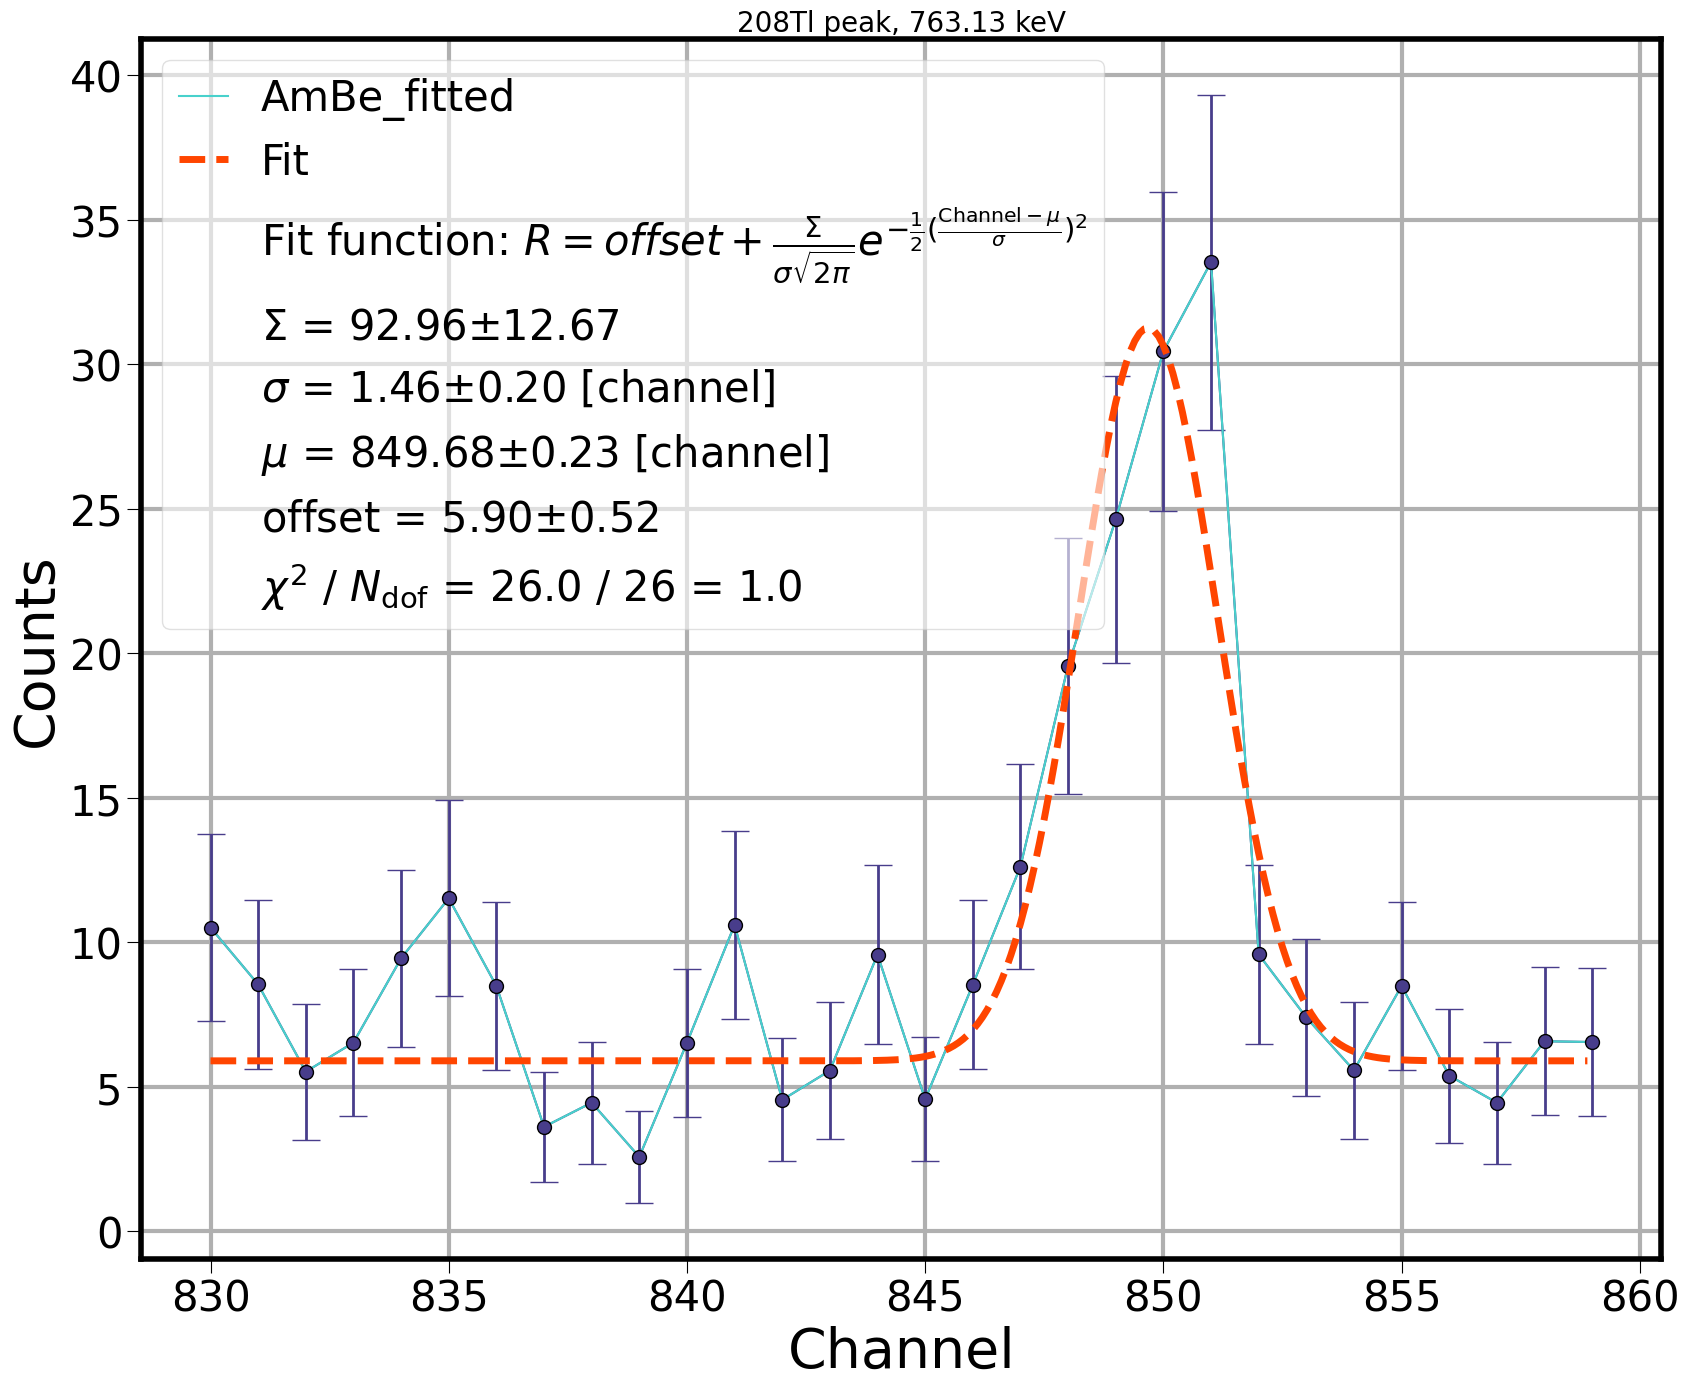

In [13]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()










ch1=830
ch2=860
ch3=830
ch4=860

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])



handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 200
mu00 = 844
sig00 = 2 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Bi peak, 785.37 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 117.2 (chi2/ndof = 7.3)    │              Nfcn = 259              │
│ EDM = 0.000109 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │  -0.3e6   │   3.3e6   │            │            │         │         │       │
│ 1 │ sig    │    0.7    │    0.6    │            │            │         │         │       │
│ 2 │ mu     │   882.3   │    1.4    │            │            │         │         │       │
│ 3 │ offset │    9.8    │    0.7    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────┐
│        │         A       sig        mu    offset │
├────────┼─────────────────────────────────────────┤
│      A │   1.1e+13  1.72e+06  1.72e+06 -1.49e+04 │
│    sig │  1.72e+06     0.344     0.608   0.00313 │
│     mu │  1.72e+06     0.608      1.82   -0.0115 │
│ offset │ -1.49e+04   0.00313   -0.0115     0.511 │
└────────┴─────────────────────────────────────────┘

<ValueView A=-272155.9222794824 sig=0.7048876357650908 mu=882.3253741503305 offset=9.820587842414906>
<ErrorView A=3323656.476782183 sig=0.5864272690582123 mu=1.3483520475197068 offset=0.7148251367988336>
(-272155.9222794824, 0.7048876357650908, 882.3253741503305, 9.820587842414906)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:218: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71c088e10> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:261: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71c088e10> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

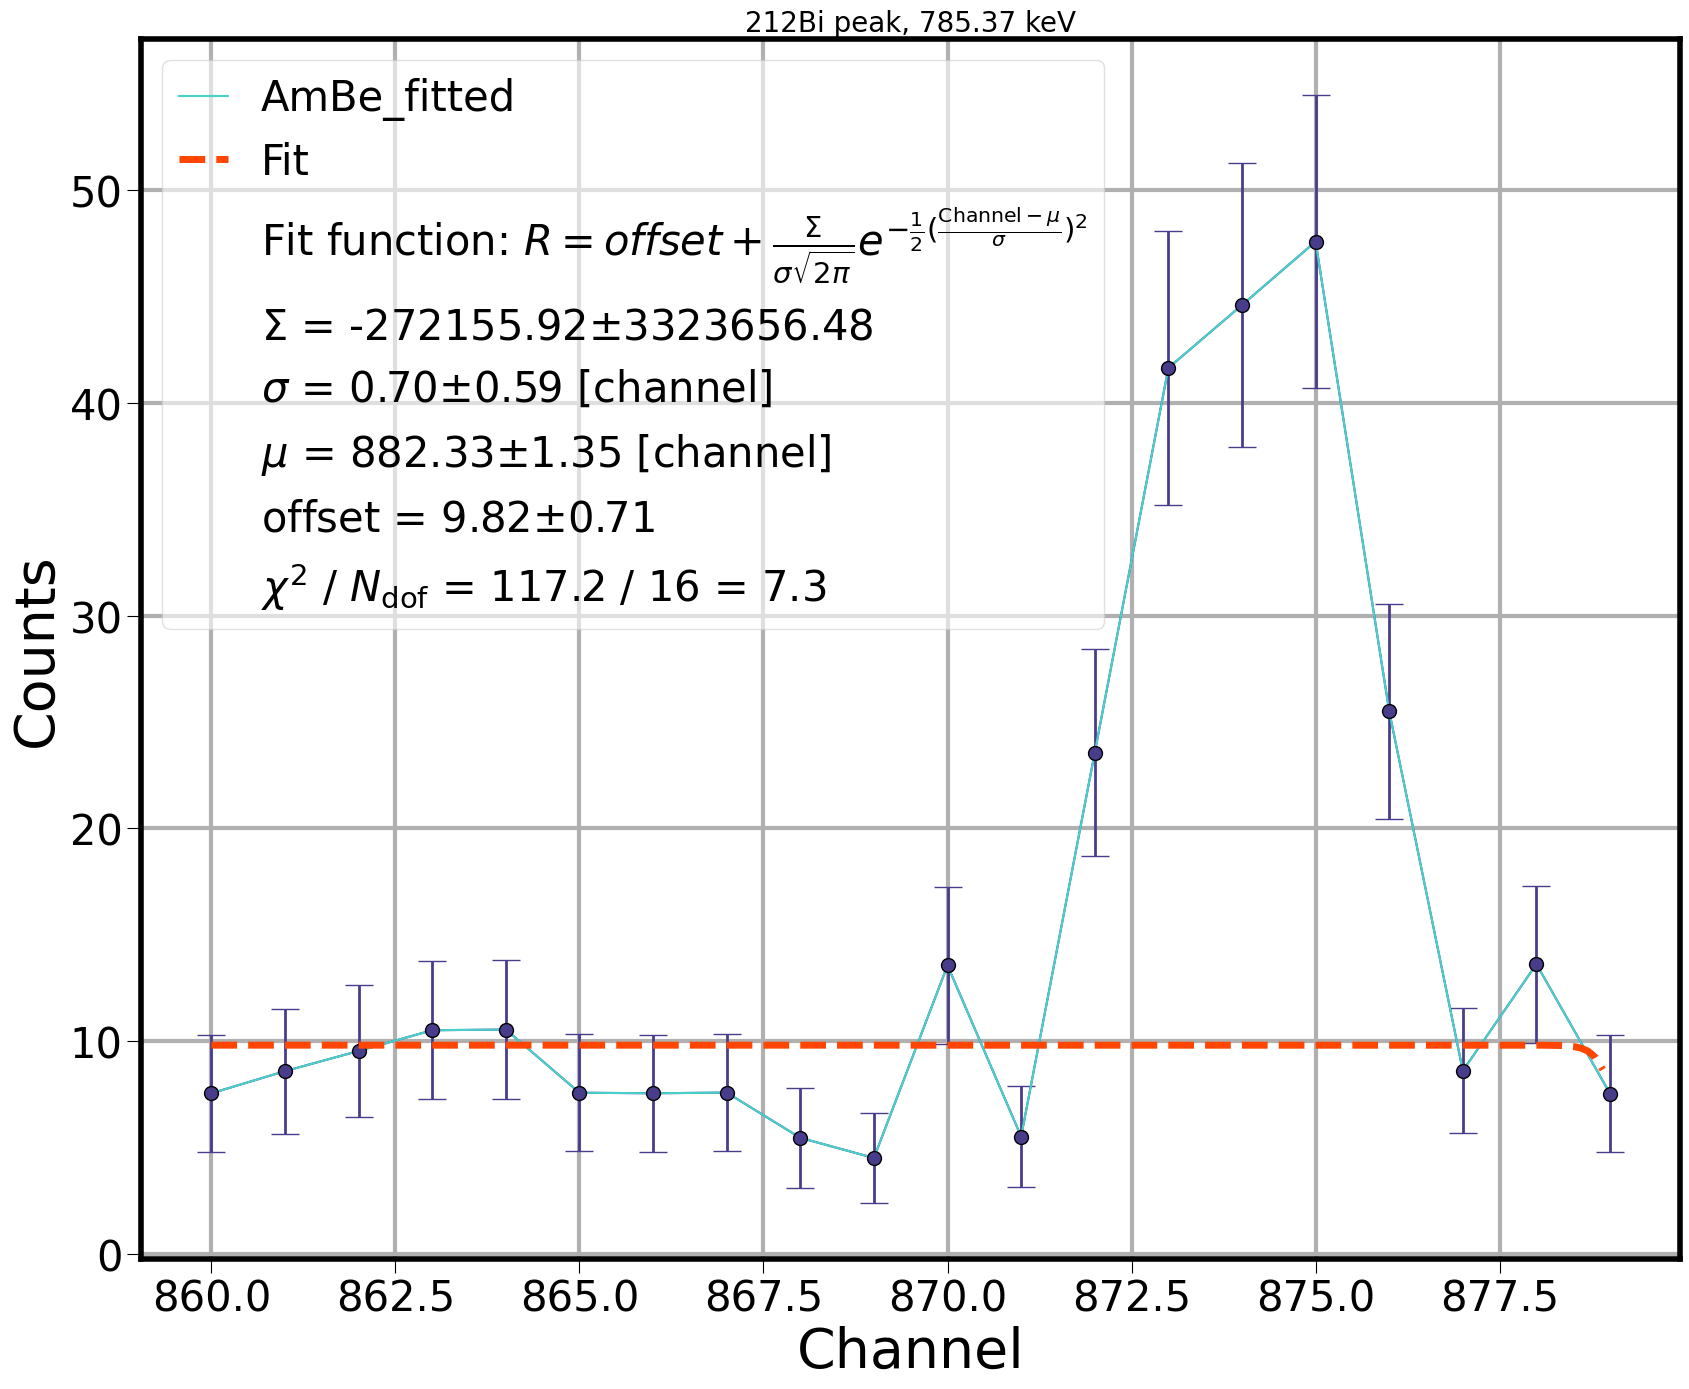

In [14]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()










ch1=860
ch2=880
ch3=860
ch4=880

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 500
mu00 = 867
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl peak, 860.564 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 74.28 (chi2/ndof = 2.1)    │              Nfcn = 115              │
│ EDM = 1.8e-07 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    627    │    26     │            │            │         │         │       │
│ 1 │ sig    │   1.61    │   0.05    │            │            │         │         │       │
│ 2 │ mu     │  957.51   │   0.07    │            │            │         │         │       │
│ 3 │ offset │    3.9    │    0.4    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────┐
│        │        A      sig       mu   offset │
├────────┼─────────────────────────────────────┤
│      A │      676    0.132  -0.0285    -1.27 │
│    sig │    0.132  0.00275 0.000605 -0.00341 │
│     mu │  -0.0285 0.000605  0.00443 0.000355 │
│ offset │    -1.27 -0.00341 0.000355    0.131 │
└────────┴─────────────────────────────────────┘

<ValueView A=626.9232260131845 sig=1.6106469920319242 mu=957.5082679419701 offset=3.9105784214718424>
<ErrorView A=26.00773952670216 sig=0.0524692641173381 mu=0.06657330931223907 offset=0.36223494657689365>
(626.9232260131845, 1.6106469920319242, 957.5082679419701, 3.9105784214718424)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:217: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71c3e57f0> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:260: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71c3e57f0> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

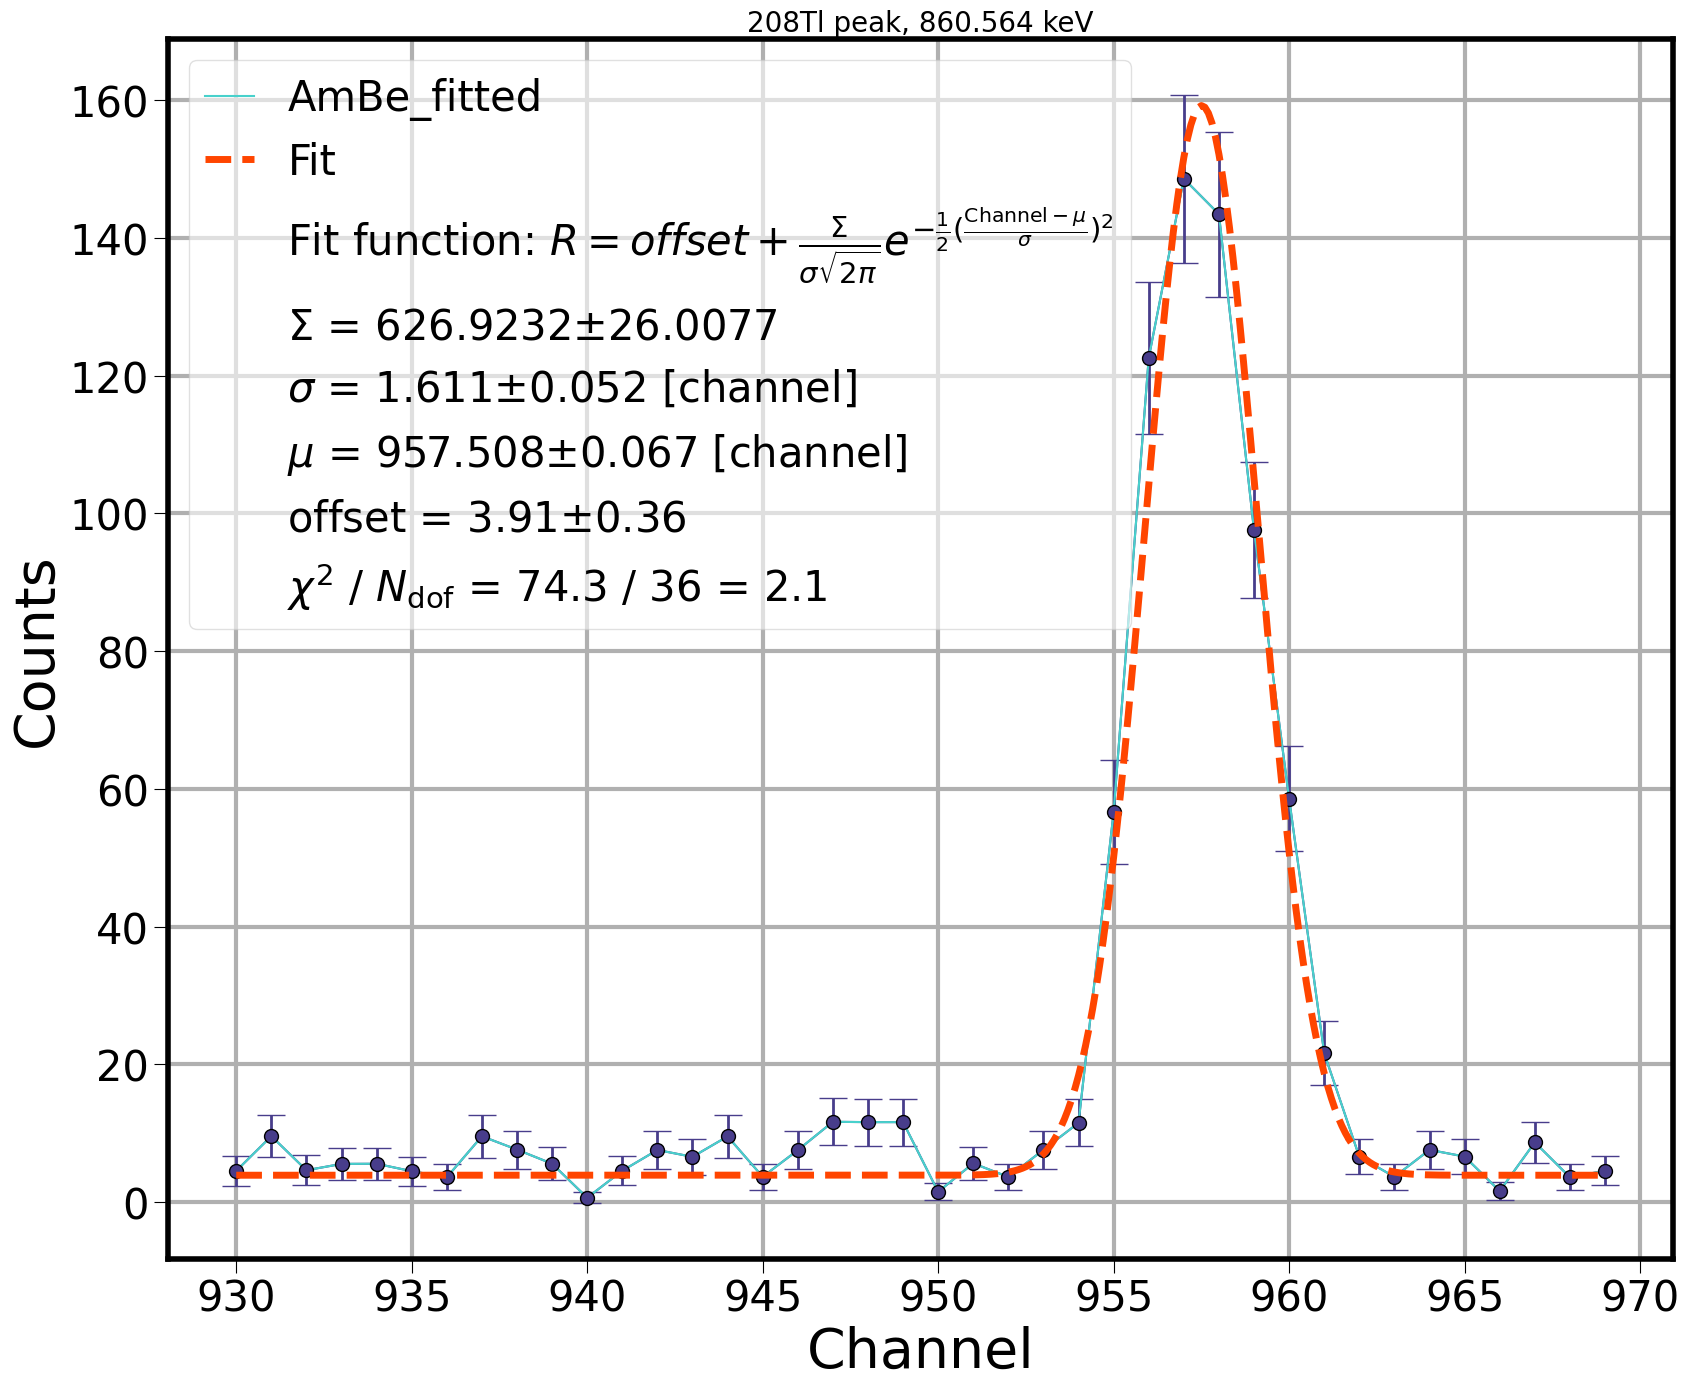

In [15]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()










ch1=930
ch2=970
ch3=930
ch4=970

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])



handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 500
mu00 = 950
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Bi peak, 893.408 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 54.61 (chi2/ndof = 2.1)    │              Nfcn = 83               │
│ EDM = 4.59e-10 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    40     │     2     │            │            │         │         │       │
│ 1 │ sig    │    4.7    │    2.0    │            │            │         │         │       │
│ 2 │ mu     │ 1.0229e3  │ 0.0020e3  │            │            │         │         │       │
│ 3 │ offset │    5.4    │    0.4    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────┐
│        │         A       sig        mu    offset │
├────────┼─────────────────────────────────────────┤
│      A │         4  1.48e-05 -2.53e-07 -3.59e-08 │
│    sig │  1.48e-05         4  -0.00021 -2.99e-05 │
│     mu │ -2.53e-07  -0.00021         4  5.33e-07 │
│ offset │ -3.59e-08 -2.99e-05  5.33e-07     0.172 │
└────────┴─────────────────────────────────────────┘

<ValueView A=39.99999511935769 sig=4.715284378193963 mu=1022.9230240236619 offset=5.385611303080395>
<ErrorView A=1.9997447112727798 sig=1.9999980040831316 mu=1.9997576878656742 offset=0.4144970512231537>
(39.99999511935769, 4.715284378193963, 1022.9230240236619, 5.385611303080395)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:218: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff7196ee828> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:261: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff7196ee828> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

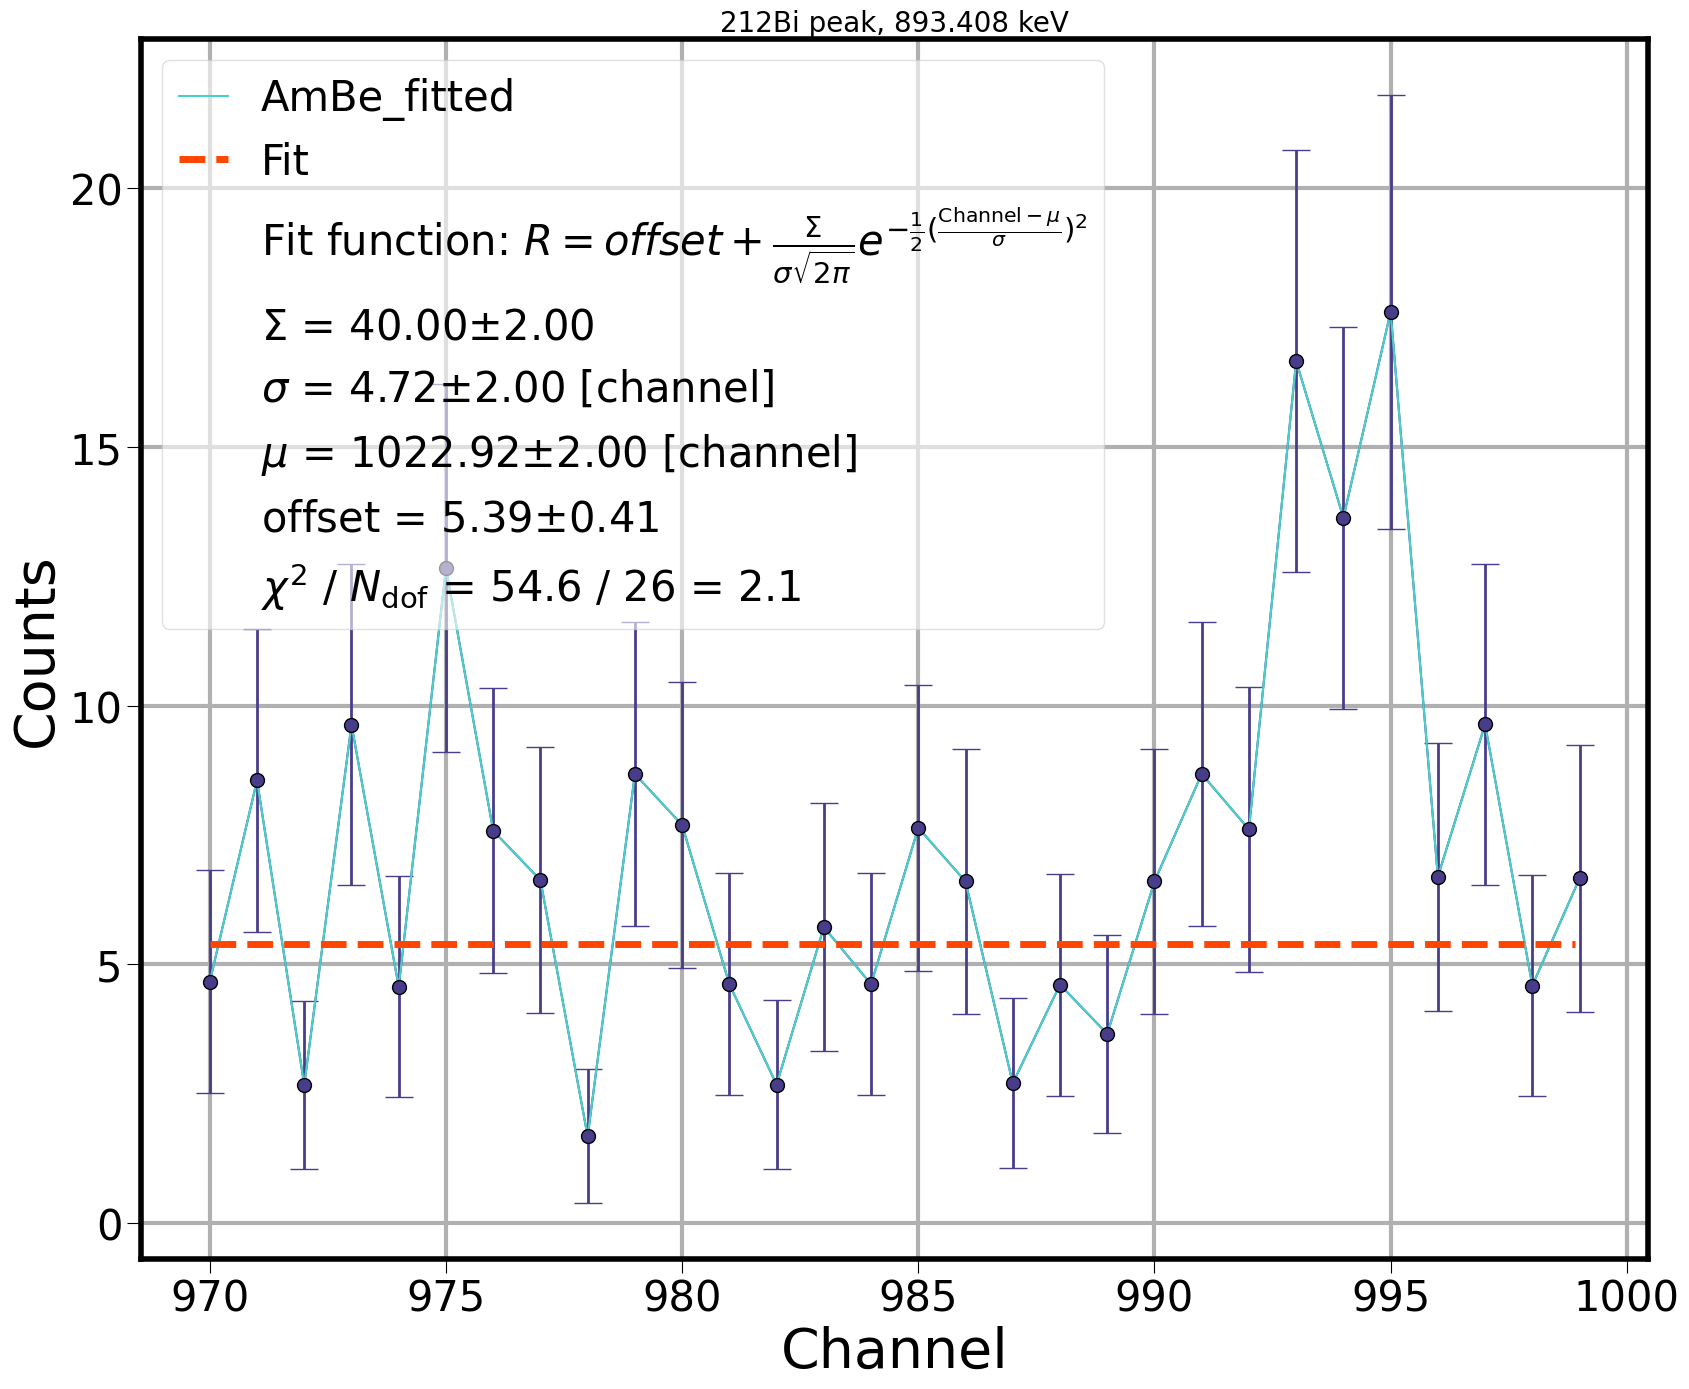

In [16]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()










ch1=970
ch2=1000
ch3=970
ch4=1000

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 40
mu00 = 990
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Bi peak, 1078.62 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 32.3 (chi2/ndof = 1.5)     │              Nfcn = 288              │
│ EDM = 9.76e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    74     │    11     │            │            │         │         │       │
│ 1 │ sig    │   1.62    │   0.19    │            │            │         │         │       │
│ 2 │ mu     │ 1.19982e3 │ 0.00026e3 │            │            │         │         │       │
│ 3 │ offset │    2.7    │    0.4    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────┐
│        │        A      sig       mu   offset │
├────────┼─────────────────────────────────────┤
│      A │      113     0.62    0.107    -1.56 │
│    sig │     0.62   0.0366   0.0127  -0.0236 │
│     mu │    0.107   0.0127   0.0675 -0.00328 │
│ offset │    -1.56  -0.0236 -0.00328    0.171 │
└────────┴─────────────────────────────────────┘

<ValueView A=73.63303180872673 sig=1.6188027117689057 mu=1199.819447398462 offset=2.7462674661011612>
<ErrorView A=10.644251742677806 sig=0.19132167617280546 mu=0.2597571259812081 offset=0.41400276267612696>
(73.63303180872673, 1.6188027117689057, 1199.819447398462, 2.7462674661011612)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:218: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71bffc940> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:261: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71bffc940> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

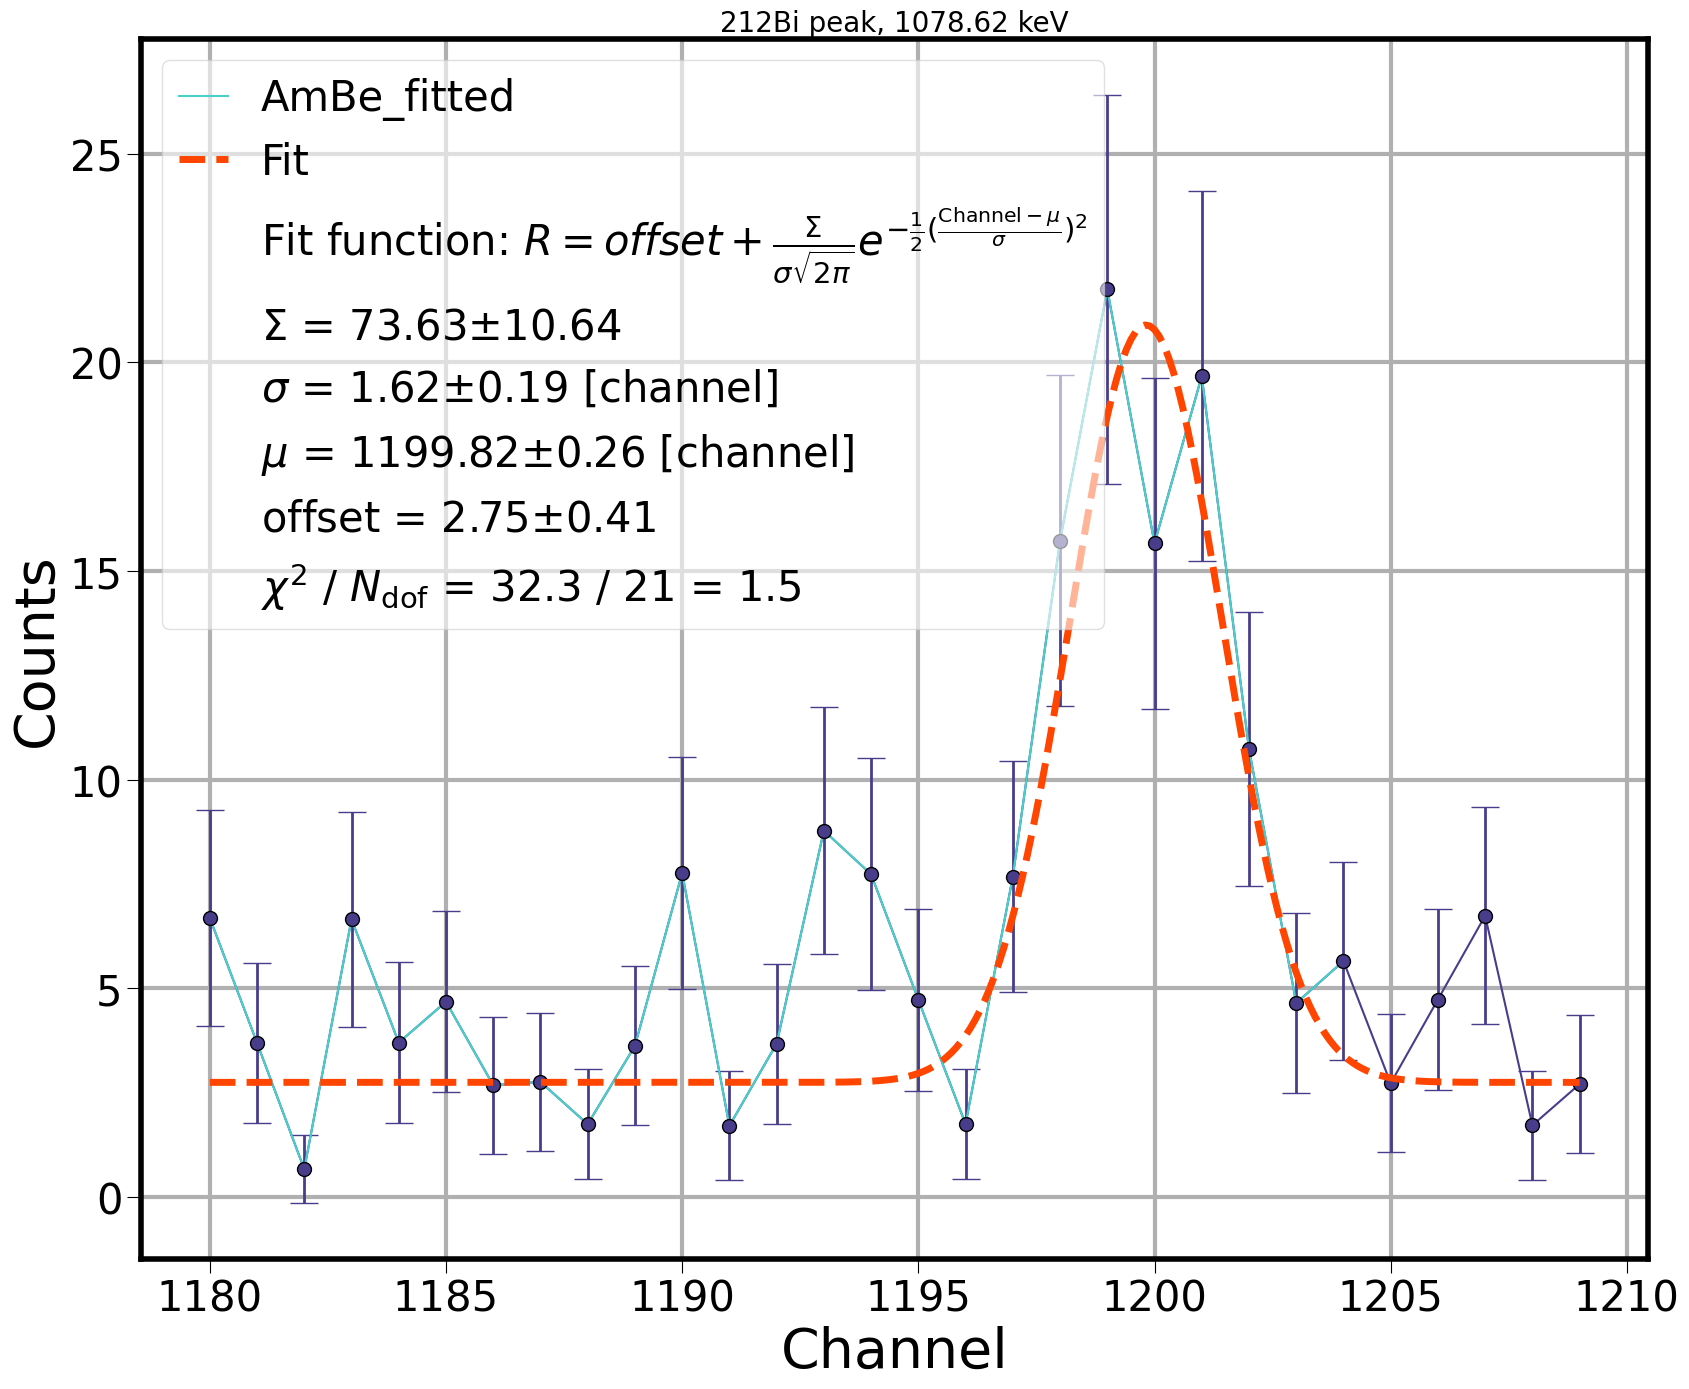

In [17]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()










ch1=1180
ch2=1205
ch3=1180
ch4=1210

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 500
mu00 = 1200
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl peak, 1093.9 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 39.14 (chi2/ndof = 1.5)    │              Nfcn = 382              │
│ EDM = 3.84e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    17     │     9     │            │            │         │         │       │
│ 1 │ sig    │    2.3    │    1.0    │            │            │         │         │       │
│ 2 │ mu     │ 1.2156e3  │ 0.0013e3  │            │            │         │         │       │
│ 3 │ offset │    3.9    │    0.5    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────┐
│        │       A     sig      mu  offset │
├────────┼─────────────────────────────────┤
│      A │    86.8    4.71       1   -2.32 │
│    sig │    4.71    1.03   0.241  -0.157 │
│     mu │       1   0.241    1.69 -0.0334 │
│ offset │   -2.32  -0.157 -0.0334   0.208 │
└────────┴─────────────────────────────────┘

<ValueView A=17.279395965659244 sig=2.3127397400896315 mu=1215.5957541278683 offset=3.9263955037047515>
<ErrorView A=9.316164275848207 sig=1.0170743366580142 mu=1.2987999928885194 offset=0.4560855781872706>
(17.279395965659244, 2.3127397400896315, 1215.5957541278683, 3.9263955037047515)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:218: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71c1cf710> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:261: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71c1cf710> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

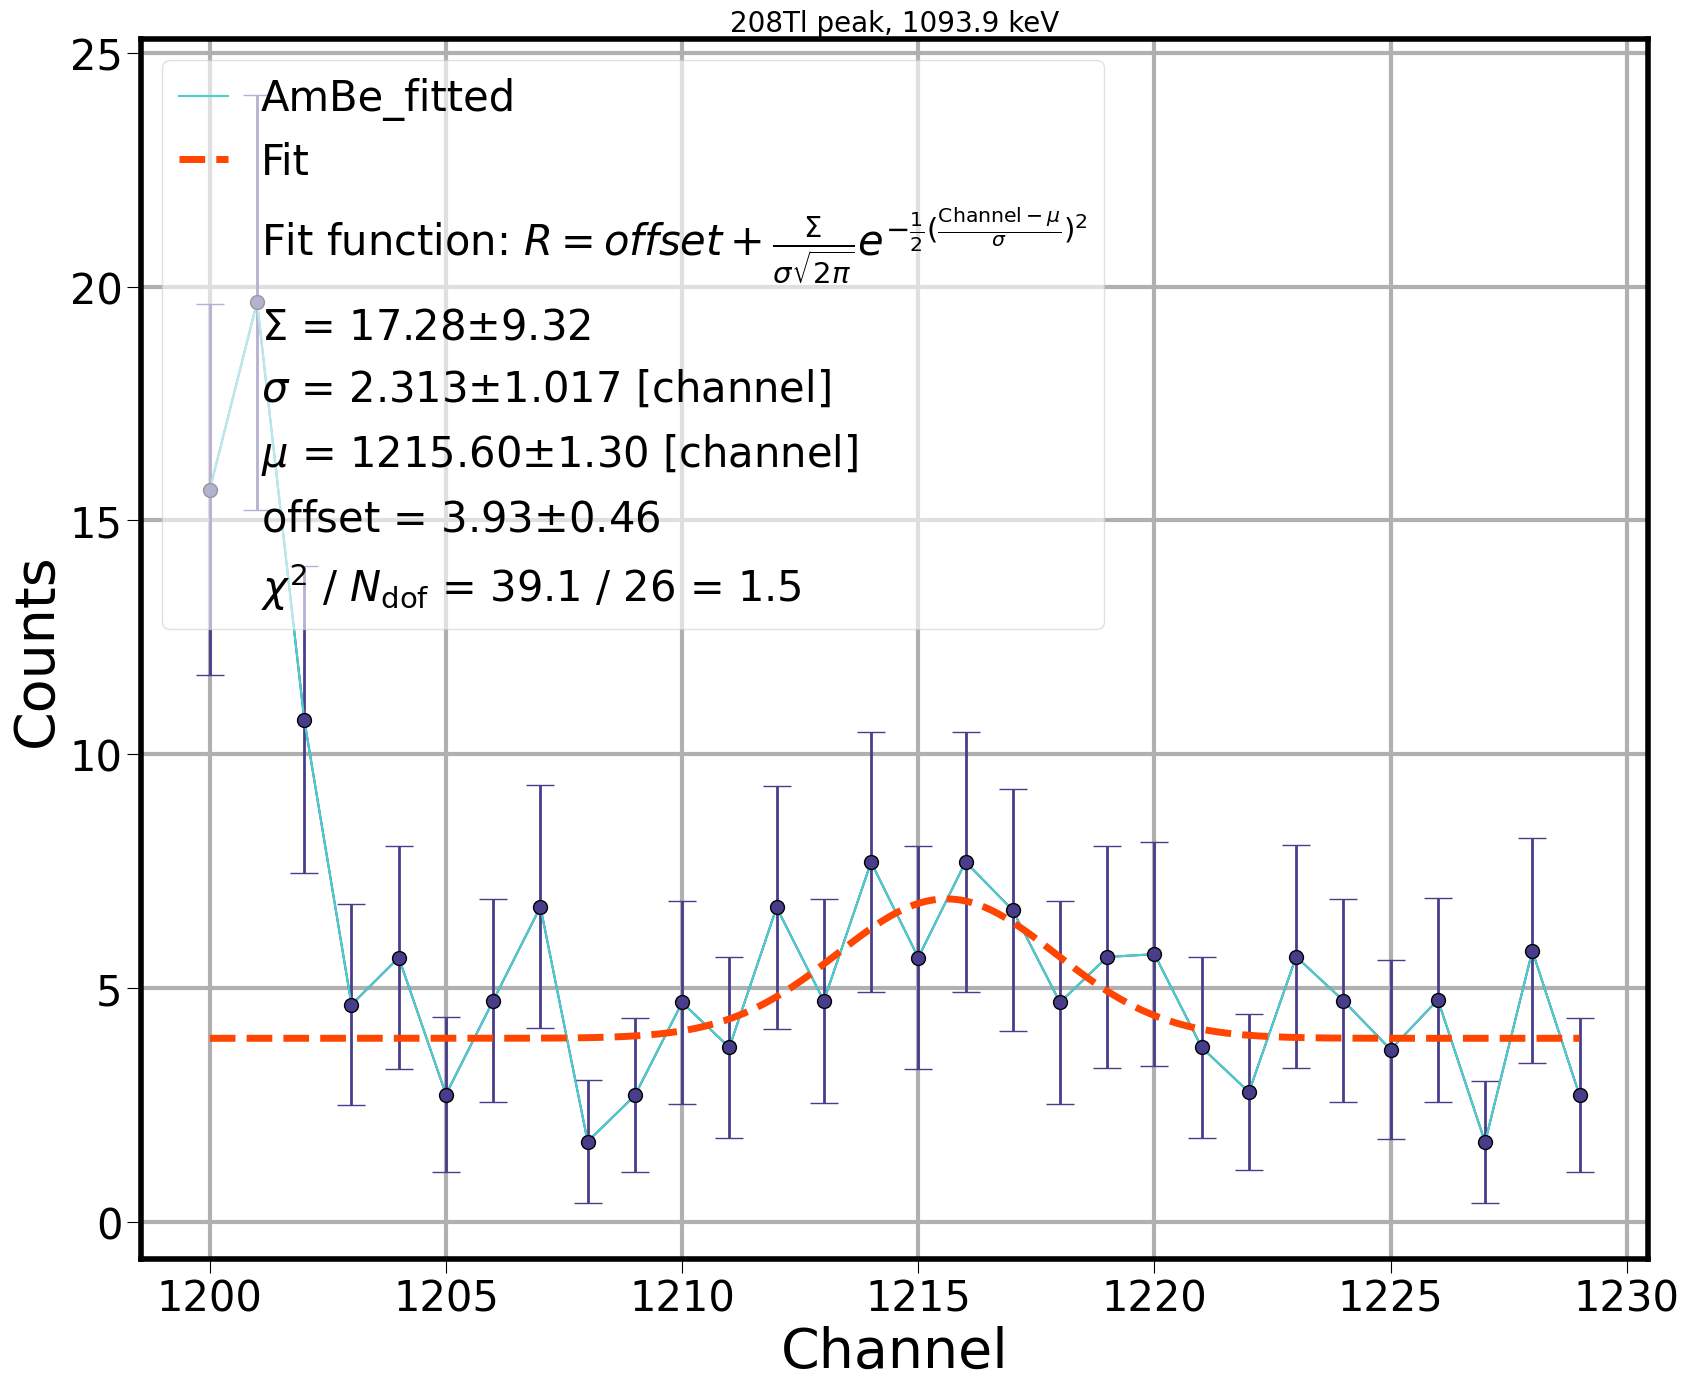

In [18]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()










ch1=1200
ch2=1230
ch3=1200
ch4=1230

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 500
mu00 = 1210
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Bi peak, 1512.7 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 48.16 (chi2/ndof = 1.0)    │              Nfcn = 236              │
│ EDM = 2.25e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    92     │    11     │            │            │         │         │       │
│ 1 │ sig    │   1.61    │   0.21    │            │            │         │         │       │
│ 2 │ mu     │ 1.62473e3 │ 0.00024e3 │            │            │         │         │       │
│ 3 │ offset │   2.19    │   0.23    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────┐
│        │       A     sig      mu  offset │
├────────┼─────────────────────────────────┤
│      A │     118   0.512  -0.221  -0.516 │
│    sig │   0.512  0.0458 -0.0281 -0.0103 │
│     mu │  -0.221 -0.0281  0.0581 0.00442 │
│ offset │  -0.516 -0.0103 0.00442  0.0542 │
└────────┴─────────────────────────────────┘

<ValueView A=92.46832381376443 sig=1.6085869602677094 mu=1624.725918703767 offset=2.1919955312413832>
<ErrorView A=10.874819855157819 sig=0.21391076327746059 mu=0.24097132789523515 offset=0.2327410831611096>
(92.46832381376443, 1.6085869602677094, 1624.725918703767, 2.1919955312413832)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:218: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71c226860> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:261: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71c226860> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

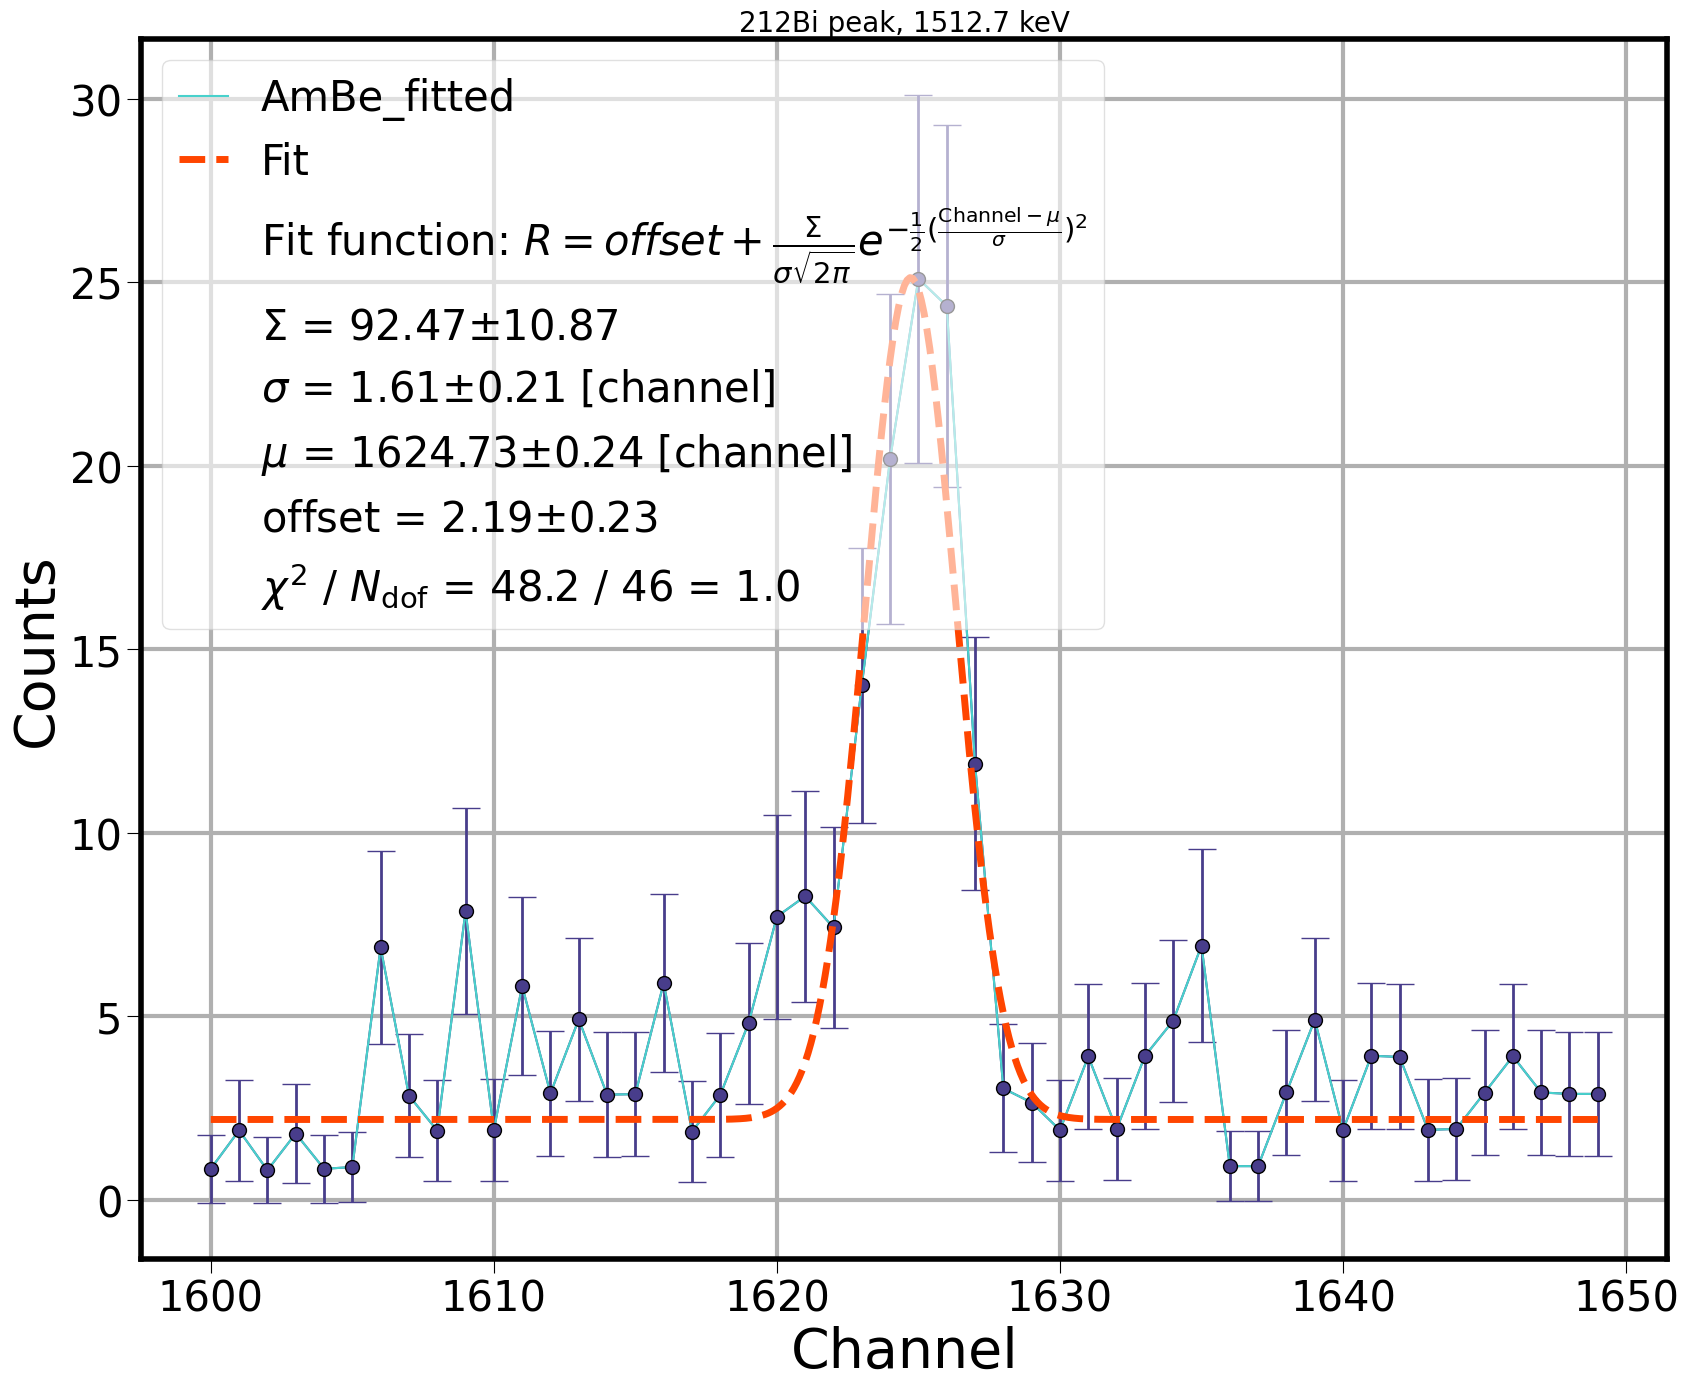

In [19]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()










ch1=1600
ch2=1650
ch3=1600
ch4=1650

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 500
mu00 = 1620
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl peak, 1592.511 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in sqrt


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 118.5 (chi2/ndof = 3.3)    │              Nfcn = 766              │
│ EDM = 9.01e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           ABOVE call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │ 6.3844e6  │ 0.0000e6  │            │            │         │         │       │
│ 1 │ sig    │ 7.7679e1  │ 0.0000e1  │            │            │         │         │       │
│ 2 │ mu     │ 2.1014e3  │ 0.0000e3  │            │            │         │         │       │
│ 3 │ offset │-3.6527e-1 │ 0.0000e-1 │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:220: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71af53a58> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:263: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71af53a58> has a label of '_child0' which cannot be automatically added to the legend.


<ValueView A=6384376.978248061 sig=77.67949355776989 mu=2101.4378210521554 offset=-0.3652746233477527>
<ErrorView A=0.0 sig=0.0 mu=0.0 offset=0.0>
(6384376.978248061, 77.67949355776989, 2101.4378210521554, -0.3652746233477527)


<Figure size 1700x1400 with 0 Axes>

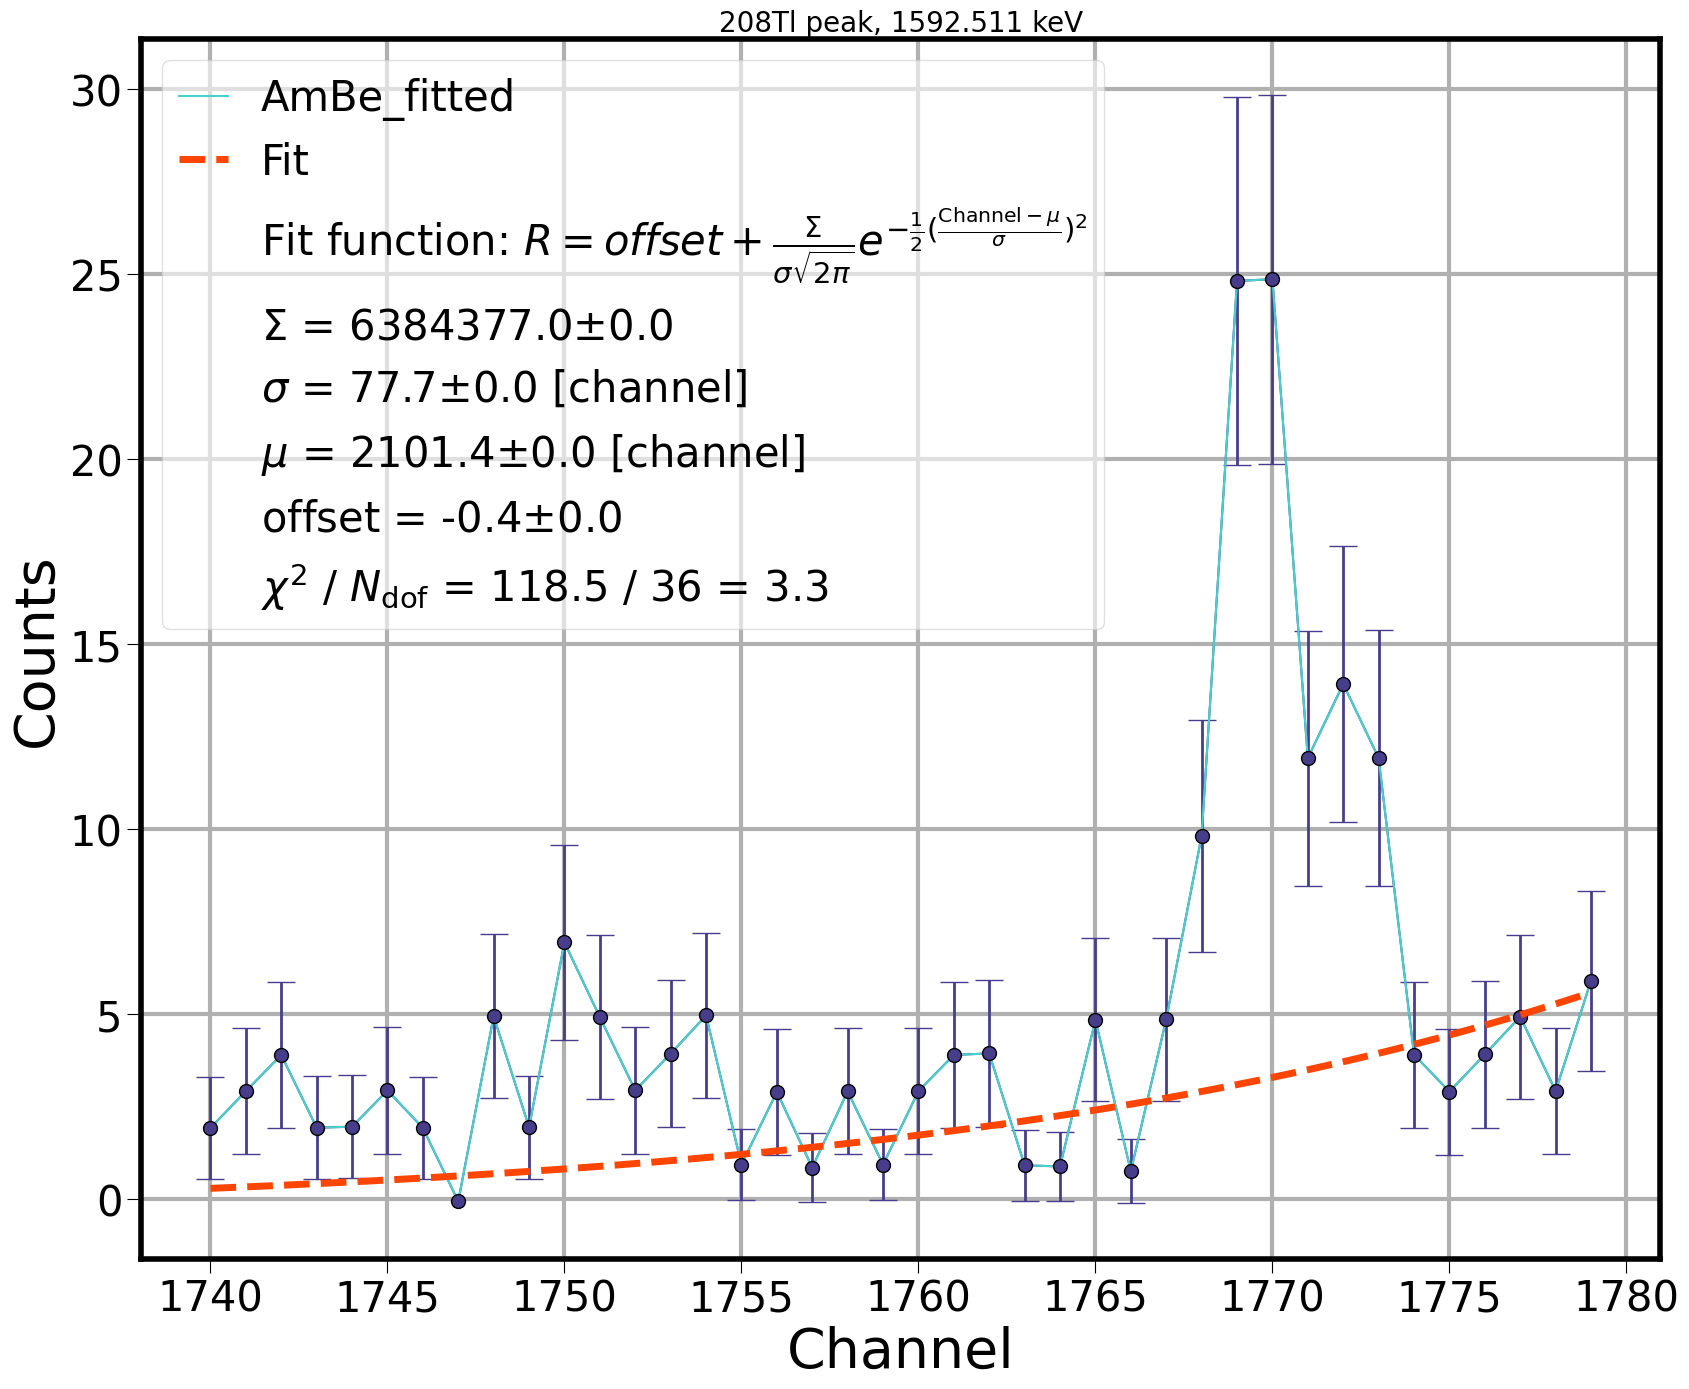

In [20]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()










ch1=1740
ch2=1780
ch3=1740
ch4=1780

#print(signal[ch1:ch2])


channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
#rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])
rate_no_bkg_err_to_fit=np.sqrt(np.abs(signal[ch1:ch2]))


handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 500
mu00 = 1760
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '212Bi peak, 1620.5 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 135.2 (chi2/ndof = 5.2)    │              Nfcn = 247              │
│ EDM = 1.92e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │APPROXIMATE│NOT pos. def.│   FORCED   │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │ -0.003e6  │  0.012e6  │            │            │         │         │       │
│ 1 │ sig    │    2.0    │    1.4    │            │            │         │         │       │
│ 2 │ mu     │ 1.8153e3  │ 0.0029e3  │            │            │         │         │       │
│ 3 │ offset │    4.9    │    0.4    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────┐
│        │        A      sig       mu   offset │
├────────┼─────────────────────────────────────┤
│      A │ 1.32e+08 1.14e+04  1.5e+03      351 │
│    sig │ 1.14e+04     1.99     3.01   0.0603 │
│     mu │  1.5e+03     3.01     8.44   0.0528 │
│ offset │      351   0.0603   0.0528    0.174 │
└────────┴─────────────────────────────────────┘

<ValueView A=-2558.647217854363 sig=1.9798259833513847 mu=1815.3463439311424 offset=4.937772988474968>
<ErrorView A=11496.886405495983 sig=1.4092006855080677 mu=2.9050159756963865 offset=0.41655396606025613>
(-2558.647217854363, 1.9798259833513847, 1815.3463439311424, 4.937772988474968)


/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:218: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71c15bb38> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:261: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71c15bb38> has a label of '_child0' which cannot be automatically added to the legend.


<Figure size 1700x1400 with 0 Axes>

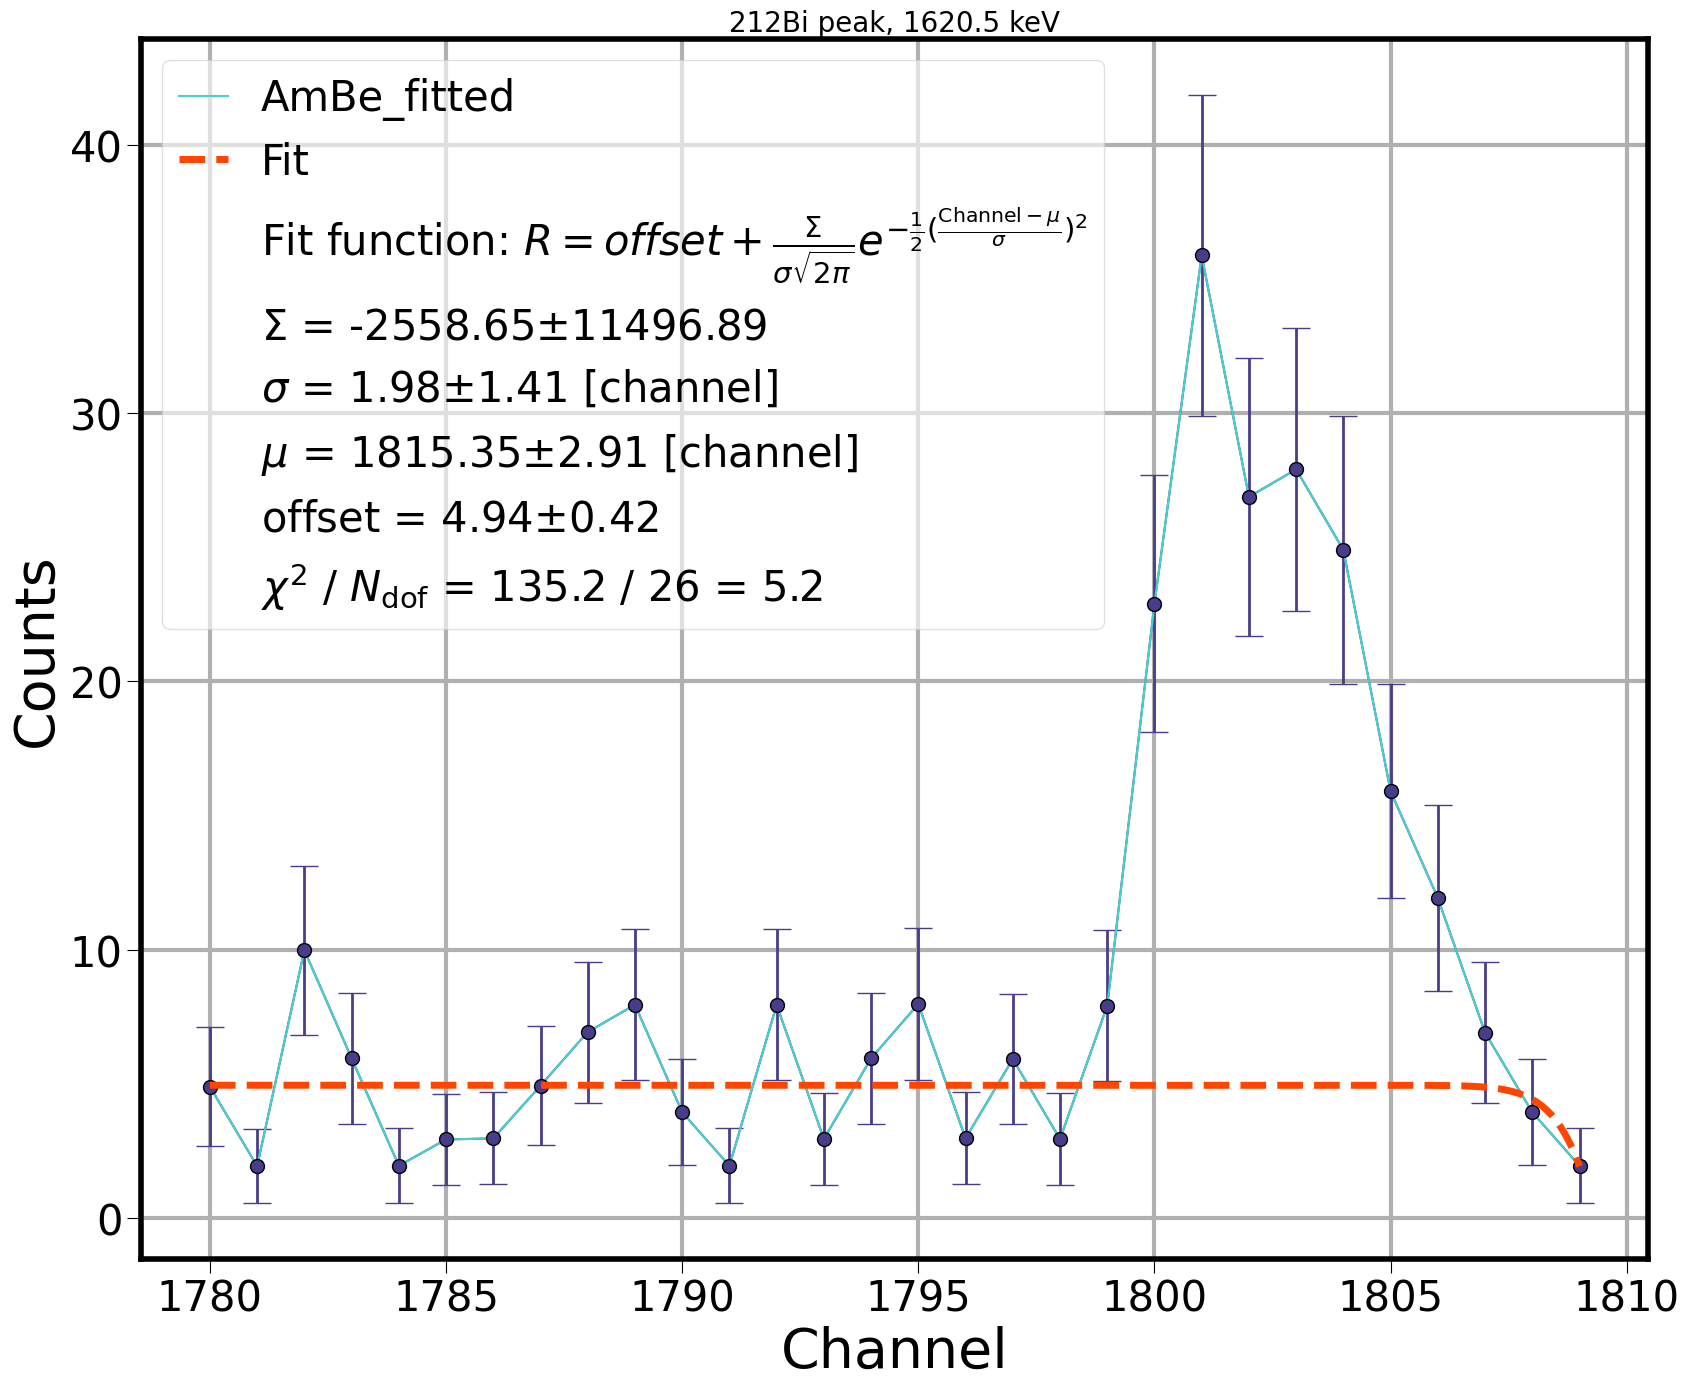

In [21]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()










ch1=1780
ch2=1810
ch3=1780
ch4=1810

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 500
mu00 = 1790
sig00 = 5 
offset00 = 10

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '208Tl SE peak, 2103.511 keV')

Text(0.5, 0, 'Channel')

Text(0, 0.5, 'Counts')

/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in sqrt


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 66.81 (chi2/ndof = 1.5)    │              Nfcn = 332              │
│ EDM = 5.15e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ A      │    283    │    19     │            │            │         │         │       │
│ 1 │ sig    │   2.69    │   0.19    │            │            │         │         │       │
│ 2 │ mu     │ 2.33810e3 │ 0.00018e3 │            │            │         │         │       │
│ 3 │ offset │   3.08    │   0.30    │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────────┬─────────────────────────────────────────┐
│        │         A       sig        mu    offset │
├────────┼─────────────────────────────────────────┤
│      A │       353     0.753    -0.012      -1.4 │
│    sig │     0.753    0.0359 -0.000433    -0.015 │
│     mu │    -0.012 -0.000433    0.0343  0.000218 │
│ offset │      -1.4    -0.015  0.000218    0.0896 │
└────────┴─────────────────────────────────────────┘

/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:218: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71c33e400> has a label of '_child0' which cannot be automatically added to the legend.
/home/amslivar/.local/lib/python3.7/site-packages/ipykernel_launcher.py:261: UserWarning: The handle <matplotlib.lines.Line2D object at 0x7ff71c33e400> has a label of '_child0' which cannot be automatically added to the legend.


<ValueView A=283.16912261504115 sig=2.691979926926717 mu=2338.1026738255828 offset=3.0824518624441053>
<ErrorView A=18.790814213251736 sig=0.18935229430504863 mu=0.18516818645322547 offset=0.2993552529474334>
(283.16912261504115, 2.691979926926717, 2338.1026738255828, 3.0824518624441053)


<Figure size 1700x1400 with 0 Axes>

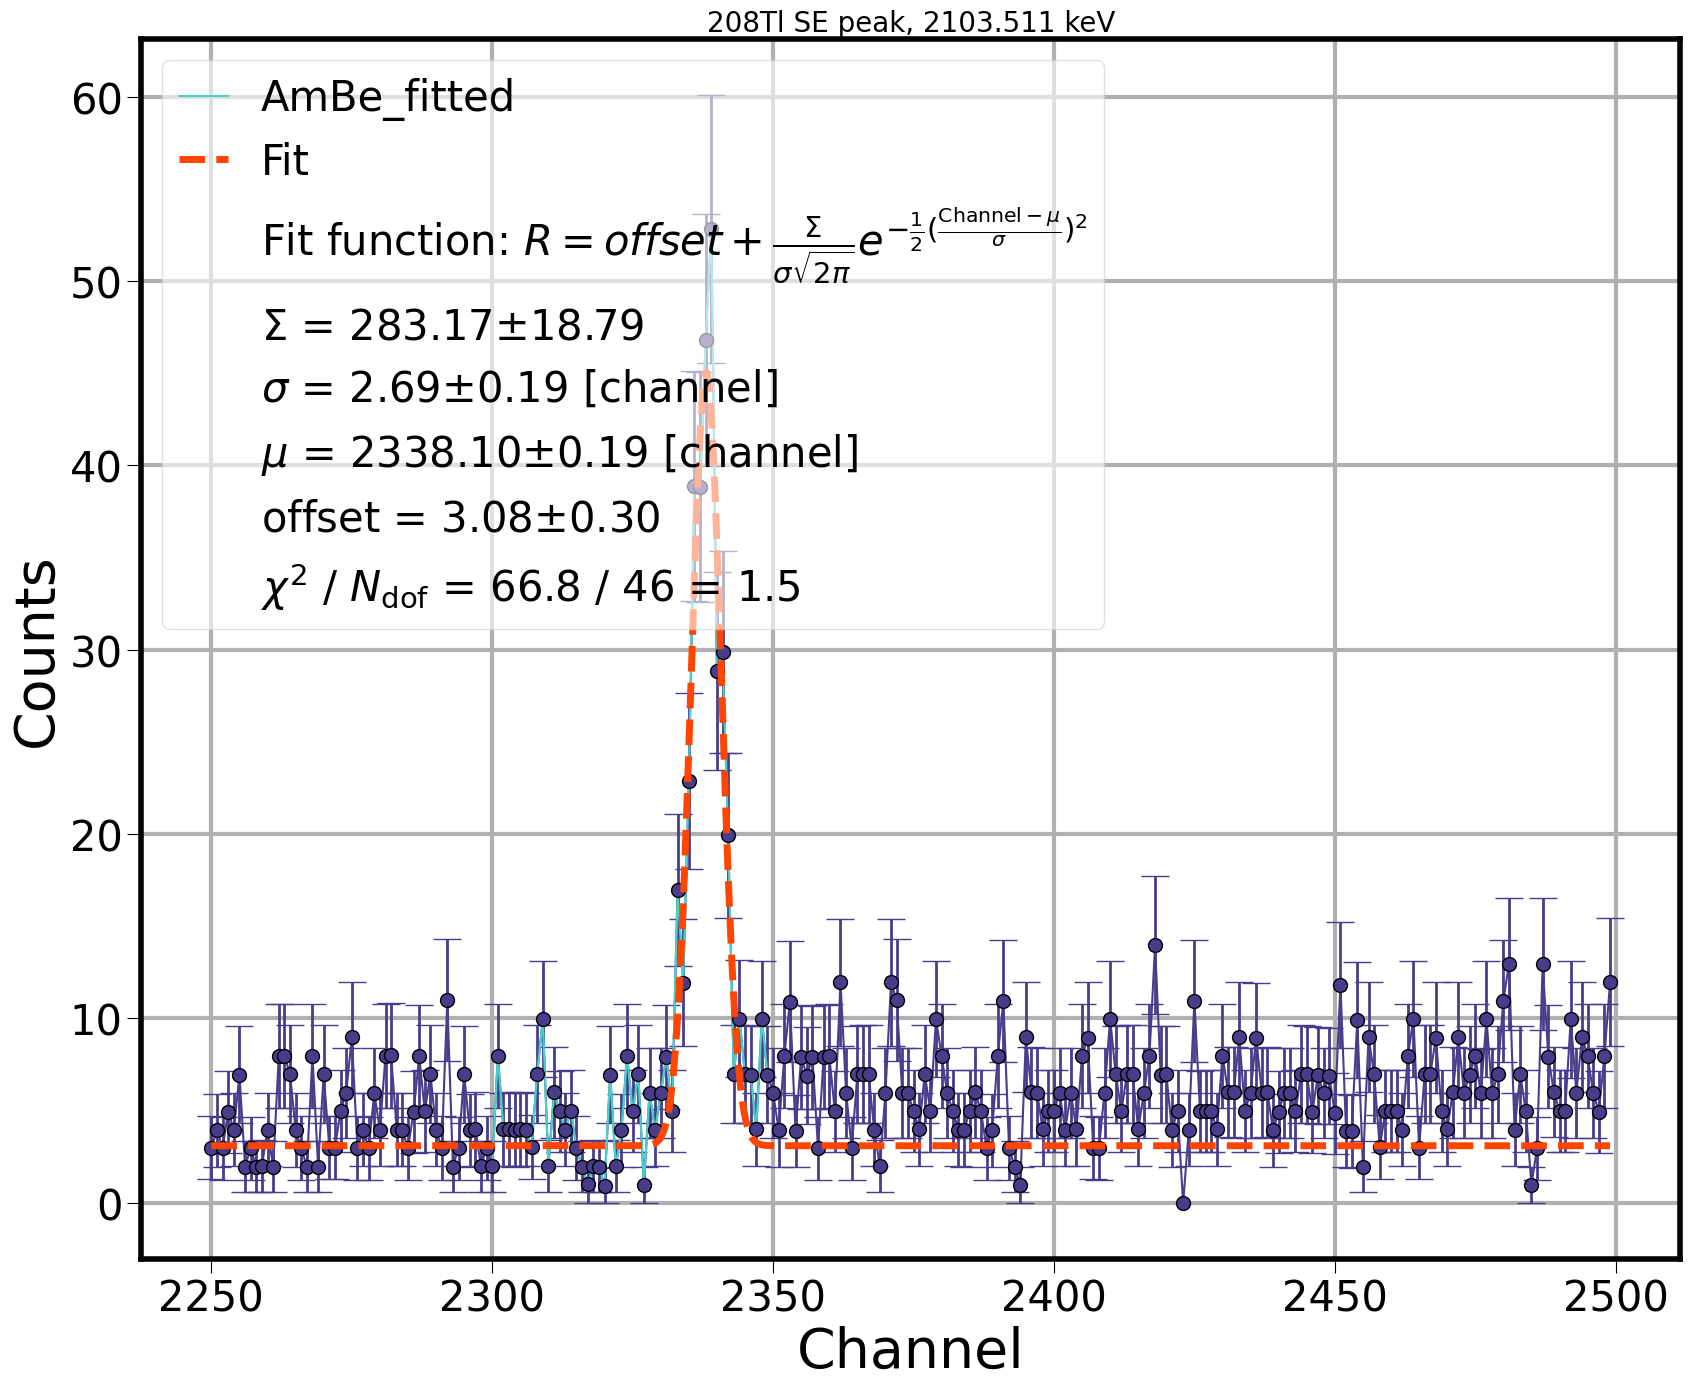

In [22]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('{} peak, {} keV'.format(Peak_name[p], Peak_energy[p]), fontsize=20)




#label the axes
ax1.set_xlabel( "Channel", fontsize=40)
ax1.set_ylabel( u"Counts", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()










ch1=2300
ch2=2350
ch3=2250
ch4=2500

channels=np.asarray(scan[0][0][ch3:ch4])
rate_no_bkg=signal[ch3:ch4]
rate_no_bkg_err=np.sqrt(signal[ch3:ch4])

channels_to_fit=np.asarray(scan[0][0][ch1:ch2])
rate_no_bkg_to_fit=signal[ch1:ch2]
rate_no_bkg_err_to_fit=np.sqrt(signal[ch1:ch2])




handlelist=[]
labellist=[]


Data, = ax1.plot(channels, rate_no_bkg, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(channels, rate_no_bkg, yerr=np.array(rate_no_bkg_err), fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(channels, rate_no_bkg, label=r'Data', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(Data)
labellist.append(Data.get_label())







#define fit function
def normal_distribution(x, A, sig, mu, offset):
    return offset+A/np.sqrt(2*math.pi)/sig * np.exp(-1/2*((x-mu)/sig)**2)





#perform a least squares fit with iminuit
least_squares = LeastSquares(channels_to_fit, rate_no_bkg_to_fit, rate_no_bkg_err_to_fit,normal_distribution)





#set initial parameter values
A00 = 4000
mu00 = 2325
sig00 = 2 
offset00 = 0

#assemble list fit arguments for the minimizer
namelist = ['A', 'sig', 'mu','offset']
kwargs = dict(A=A00, sig=sig00, mu=mu00, offset=offset00)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=chmin
t_end=chmax

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(normal_distribution(t, minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset']))
    t+=0.1

Data_fit, = ax1.plot(channels_to_fit, rate_no_bkg_to_fit, 
                          color="mediumturquoise", label="AmBe_fitted",  **error_kwargs)

handlelist.append(Data_fit)
labellist.append(Data_fit.get_label())

Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    
text10= 'Fit function: ' + r'$I_{\mathrm{FC}}(B) = bkg + \sum _{i}\frac{A_i}{\sigma _i \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{B-B^\mathrm{central}_i}{\sigma _i})^2}$'


text_chi_1 = f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg) - minuit.nfit) :.1f}"


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    





#short legend
leg = plt.legend(handles=[Data, Fit, extra, extra], 
                 labels = [Data.get_label(), Fit.get_label(), text10, text_chi_1],
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)





extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$R = offset + \frac{\Sigma}{\sigma \sqrt{2 \pi} } e^{-\frac{1}{2} (\frac{\mathrm{Channel}-\mu}{\sigma })^2}$',
      r'$\Sigma$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['A']),number_sigdigs(minuit.errors['A'])), 
                                        round(Decimal(minuit.errors['A']),number_sigdigs(minuit.errors['A']))),
      r'$\sigma$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['sig']),number_sigdigs(minuit.errors['sig'])), 
                                        round(Decimal(minuit.errors['sig']),number_sigdigs(minuit.errors['sig']))),
      r'$\mu$'+' = {}$\pm${} [channel]'.format(round(Decimal(minuit.values['mu']),number_sigdigs(minuit.errors['mu'])), 
                                        round(Decimal(minuit.errors['mu']),number_sigdigs(minuit.errors['mu']))),
      r'offset'+' = {}$\pm${}'.format(round(Decimal(minuit.values['offset']),number_sigdigs(minuit.errors['offset'])), 
                                        round(Decimal(minuit.errors['offset']),number_sigdigs(minuit.errors['offset']))),
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"'{} peak, {} keV'.png".format(Peak_name[p], Peak_energy[p]), bbox_inches ='tight')
plt.show()

Peak_channel.append(minuit.values['mu'])
Peak_channel_err.append(minuit.errors['mu'])
Sigma_channel.append(minuit.values['sig'])
Sigma_channel_err.append(minuit.errors['sig'])

p+=1


In [23]:
popindex=[13,2]
print(Peak_energy)
for pi in popindex:
    Peak_name.pop(pi)
    Peak_energy.pop(pi) 
    Peak_channel.pop(pi)
    Peak_channel_err.pop(pi)
    Sigma_channel.pop(pi)
    Sigma_channel_err.pop(pi)
    print(Peak_energy)



[115.183, 277.371, 288.2, 300.087, 510.69, 583.191, 727.33, 763.13, 785.37, 860.564, 893.408, 1078.62, 1093.9, 1512.7, 1592.511, 1620.5, 2103.511]


'212Bi'

1512.7

1624.725918703767

0.24097132789523515

1.6085869602677094

0.21391076327746059

[115.183, 277.371, 288.2, 300.087, 510.69, 583.191, 727.33, 763.13, 785.37, 860.564, 893.408, 1078.62, 1093.9, 1592.511, 1620.5, 2103.511]


'212Bi'

288.2

307.1036325375219

8.01515323711091

2.2971387657786186

2.3816506439408855

[115.183, 277.371, 300.087, 510.69, 583.191, 727.33, 763.13, 785.37, 860.564, 893.408, 1078.62, 1093.9, 1592.511, 1620.5, 2103.511]


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '228Th energy calibration curve, with attenuator')

Text(0.5, 0, 'Energy, [keV]')

Text(0, 0.5, 'Channel')

/home/amslivar/.local/lib/python3.7/site-packages/iminuit/cost.py:83: RuntimeWarning: divide by zero encountered in true_divide
  z = (y - ym) / ye


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = inf (chi2/ndof = inf)      │              Nfcn = 210              │
│ EDM = nan (Goal: 0.0002)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ ABOVE EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ p0   │   1.234   │    nan    │            │            │         │         │       │
│ 1 │ p1   │    1.1    │    nan    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬─────────┐
│    │  p0  p1 │
├────┼─────────┤
│ p0 │ nan nan │
│ p1 │ nan nan │
└────┴─────────┘

<ValueView p0=1.234 p1=1.1>
<ErrorView p0=nan p1=nan>
(1.234, 1.1)


ValueError: cannot convert float NaN to integer

<Figure size 1700x1400 with 0 Axes>

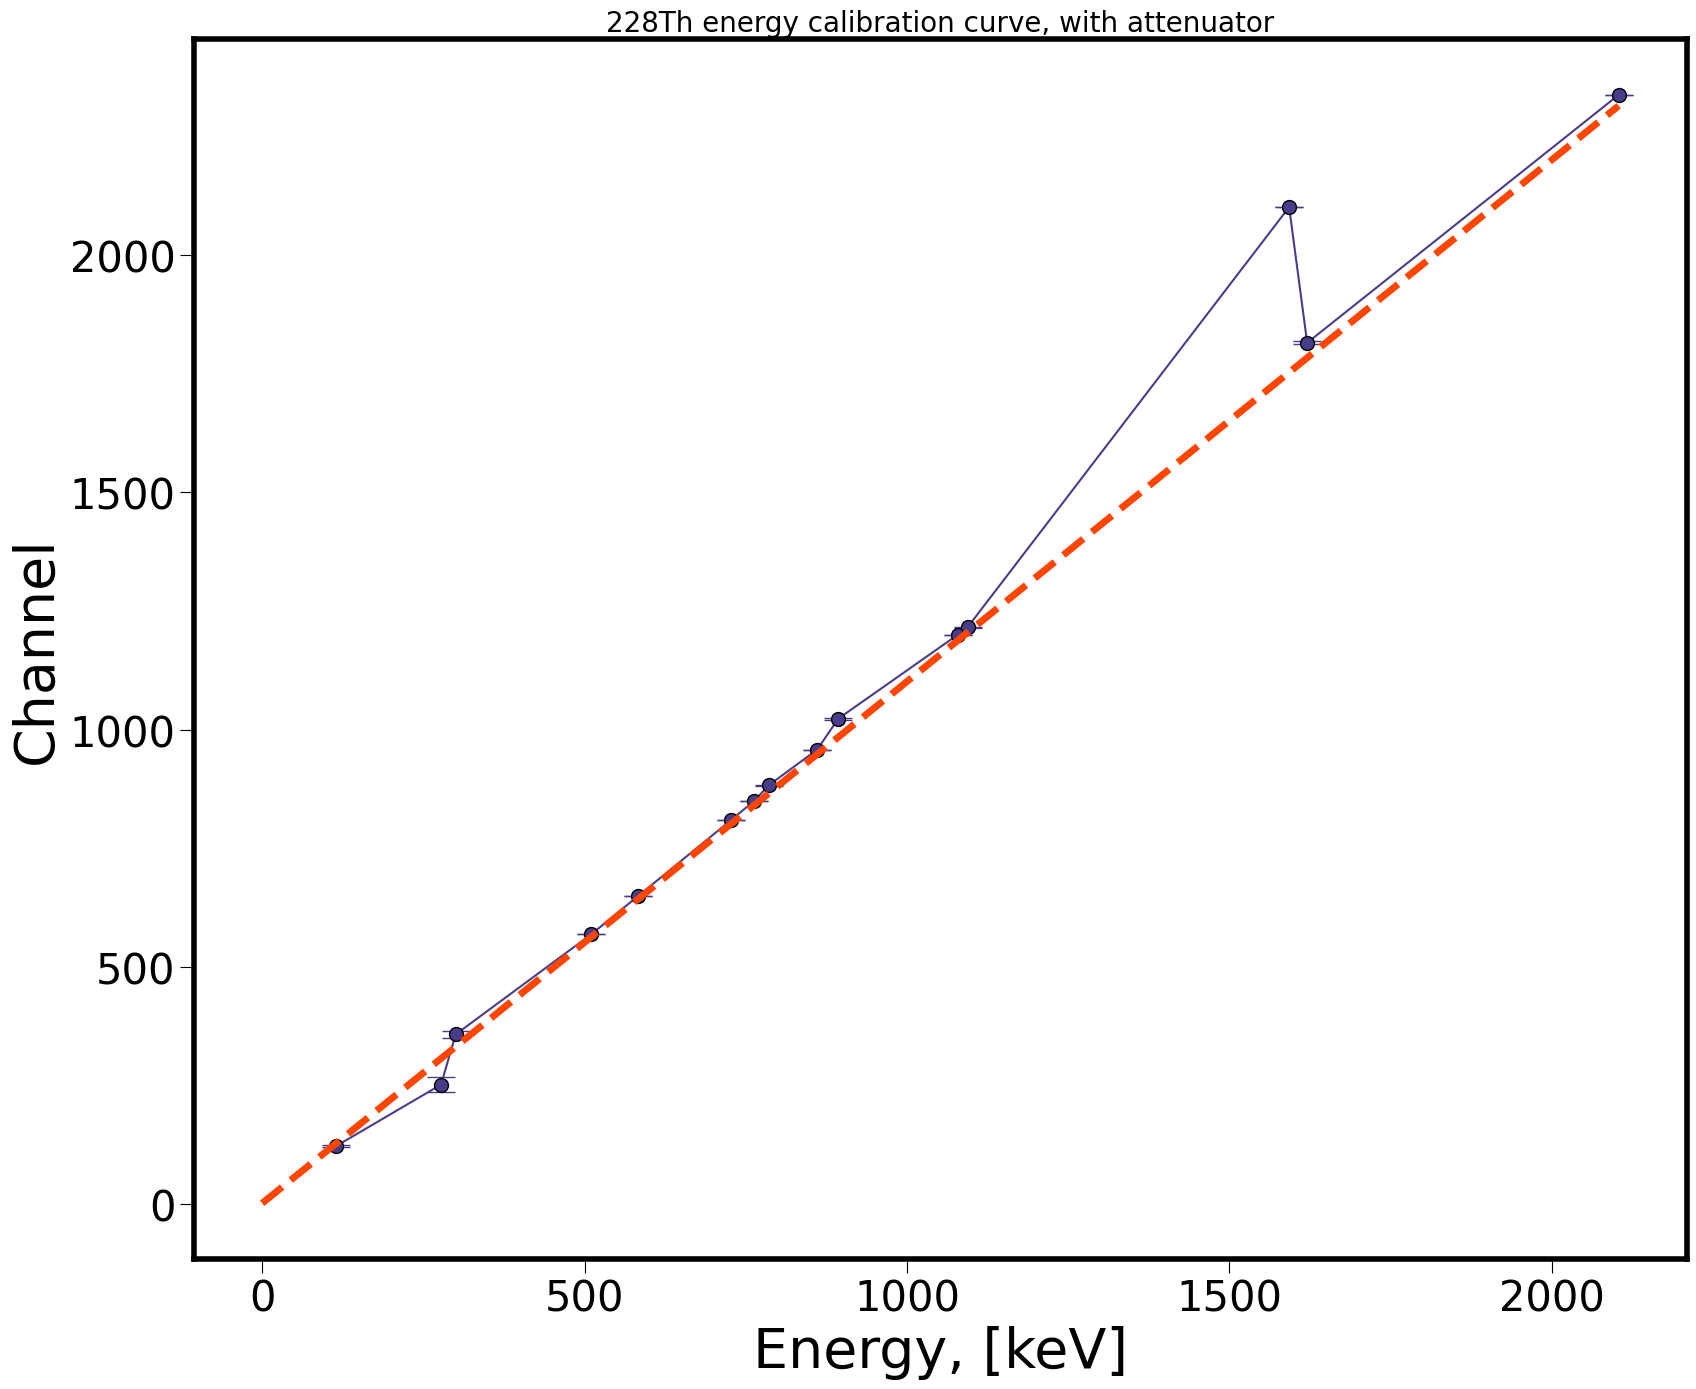

In [24]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('228Th energy calibration curve, with attenuator', fontsize=20)




#label the axes
ax1.set_xlabel( "Energy, [keV]", fontsize=40)
ax1.set_ylabel( u"Channel", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()












handlelist=[]
labellist=[]


Data, = ax1.plot(Peak_energy, Peak_channel, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(Peak_energy, Peak_channel, yerr=Peak_channel_err, fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(Peak_energy, Peak_channel, label=r'228Th peaks positions', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(data)
labellist.append(data.get_label())







#define fit function
def linear(x, p0, p1):
    return p0+p1*x





#perform a least squares fit with iminuit
least_squares = LeastSquares(Peak_energy, Peak_channel, Peak_channel_err,linear)




#set initial parameter values
p00=1.234
p10=1.1



#assemble list fit arguments for the minimizer
namelist = ['p0', 'p1']
kwargs = dict(p0=p00, p1=p10)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=0
t_end=max(Peak_energy)

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(linear(t, minuit.values['p0'], minuit.values['p1']))
    t+=0.1


Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$Channel = p0 + p1 \cdot Energy $',
      r'$p0$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['p0']),number_sigdigs(minuit.errors['p0'])), 
                                        round(Decimal(minuit.errors['p0']),number_sigdigs(minuit.errors['p0']))),
      r'$p1$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['p1']),number_sigdigs(minuit.errors['p1'])), 
                                        round(Decimal(minuit.errors['p1']),number_sigdigs(minuit.errors['p1'])))+r' [keV$^{-1}$]',
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"Calibration.png", bbox_inches ='tight')
plt.show()


<Figure size 1700x1400 with 0 Axes>

Text(0.5, 1.0, '228Th resolution calibration curve, with attenuator')

Text(0.5, 0, 'Energy, [keV]')

Text(0, 0.5, 'Sigma, [Channel]')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 44.92 (χ²/ndof = 3.5)      │              Nfcn = 33               │
│ EDM = 1.67e-19 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ p0   │   1.218   │   0.029   │            │            │         │         │       │
│ 1 │ p1   │  0.36e-3  │  0.05e-3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────────┐
│    │         p0         p1 │
├────┼───────────────────────┤
│ p0 │   0.000864 -1.2882e-6 │
│ p1 │ -1.2882e-6    2.1e-09 │
└────┴───────────────────────┘

<ValueView p0=1.2181233564104277 p1=0.00036258537347328996>
<ErrorView p0=0.029401118643535597 p1=4.5869500736522055e-05>
(1.2181233564104277, 0.00036258537347328996)


/tmp/ipykernel_5968/1821186506.py:206: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


<Figure size 1700x1400 with 0 Axes>

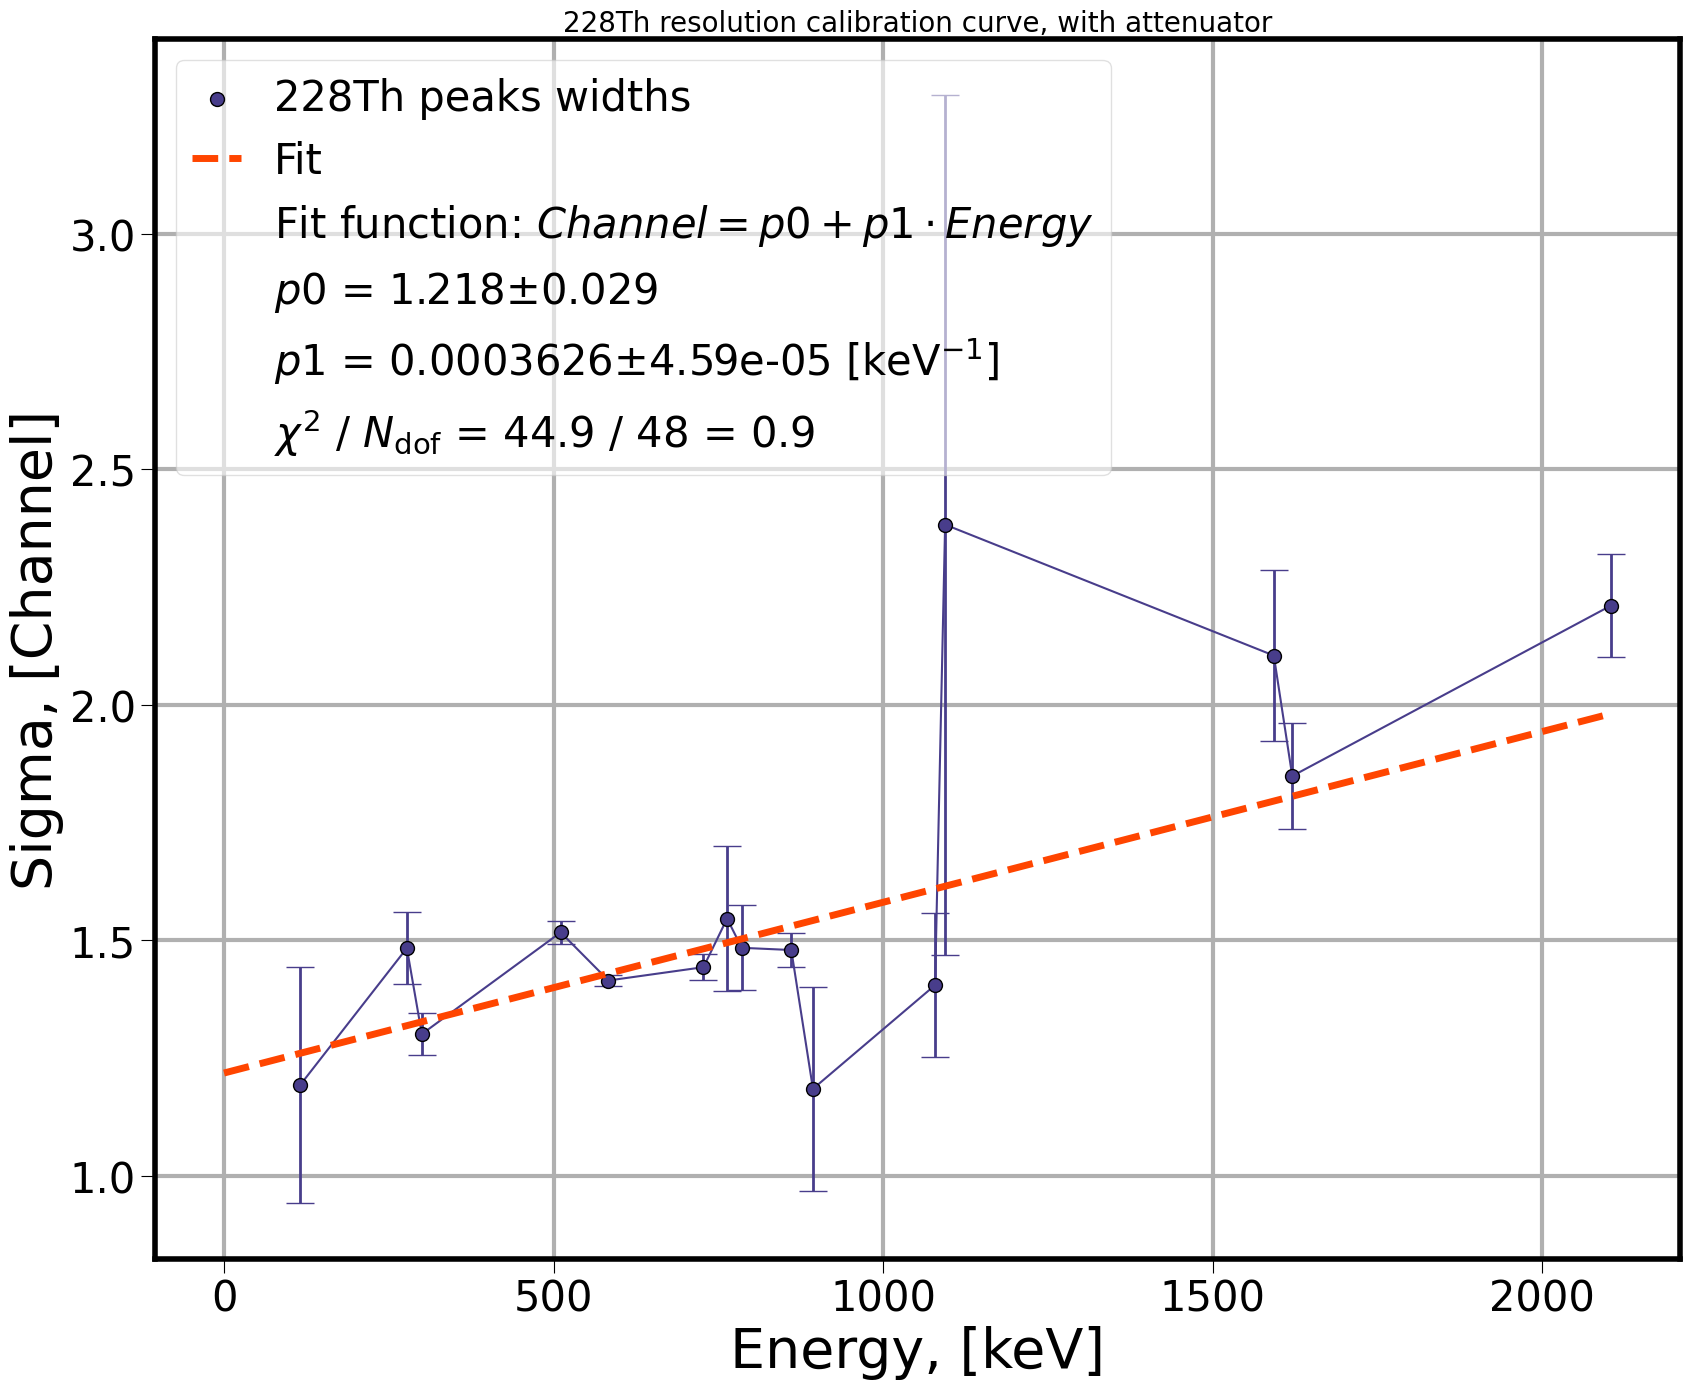

In [ ]:
#define variables for the order of plotting
analysis_extra_kwargs = {"zorder":200}
analysis_kwargs = {"zorder":100}
level_kwargs = {"zorder":80}
data_kwargs = {"zorder":50}
error_kwargs = {"zorder":25}
grid_kwargs = {"zorder":0}

#plotting parameters
label_size = 14
plt.rcParams['xtick.labelsize'] = label_size
plt.rcParams['ytick.labelsize'] = label_size
plt.rcParams['figure.figsize'] = (17.0, 14.0)
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['grid.linewidth'] = 3
matplotlib.rcParams['legend.handlelength'] = 0
matplotlib.rcParams['legend.numpoints'] = 1

plt.rcParams['legend.handlelength'] = 1.17
plt.rcParams['legend.handleheight'] = 0.65


#define fit function for average pulse
from scipy.integrate import quad
from decimal import Decimal

from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerLine2D

import iminuit


import scipy
from scipy.signal import find_peaks, peak_widths,hilbert
    
# allow complete fit output information  to be displayed
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# we also need a cost function to fit and import the LeastSquares function
from iminuit.cost import LeastSquares



plt.figure()
fig, ax1 = plt.subplots()

plt.title('228Th resolution calibration curve, with attenuator', fontsize=20)




#label the axes
ax1.set_xlabel( "Energy, [keV]", fontsize=40)
ax1.set_ylabel( u"Sigma, [Channel]", fontsize=40)

#set axes tick parameters
for tl in ax1.get_xticklabels():
    tl.set_color('black')
    tl.set_size(30)
    


for tl in ax1.get_yticklabels():
    tl.set_color('black')
    tl.set_size(30)

ax1.tick_params(length=10)

fig.tight_layout()












handlelist=[]
labellist=[]


Data, = ax1.plot(Peak_energy, Sigma_channel, 
                          color="darkslateblue",  **error_kwargs)

data_err = plt.errorbar(Peak_energy, Sigma_channel, yerr=Sigma_channel_err, fmt='o', mec='black', 
                            mew=1, color = 'darkslateblue', markersize=1, elinewidth=2, capthick=10, capsize=10, **error_kwargs)

data = ax1.scatter(Peak_energy, Sigma_channel, label=r'228Th peaks widths', edgecolors='black', 
                              marker="o", color="darkslateblue", s=100, **analysis_kwargs)


handlelist.append(data)
labellist.append(data.get_label())







#define fit function
def linear(x, p0, p1):
    return p0+p1*x





#perform a least squares fit with iminuit
least_squares = LeastSquares(Peak_energy, Sigma_channel, Sigma_channel_err,linear)




#set initial parameter values
p00=-0.41
p10=0.003



#assemble list fit arguments for the minimizer
namelist = ['p0', 'p1']
kwargs = dict(p0=p00, p1=p10)


#create iminuit minimizer
minuit = iminuit.Minuit(least_squares, **kwargs, name=namelist ) 
    
    
#set parameter limits
#minuit.limits["bkg"] = (-2e-2,0)



#run minimization  
minuit.migrad()
#minuit.minos()# run uncertainty estimator
#minuit.hesse()# run uncertainty estimator

#print fit results
print(minuit.values)
print(minuit.errors)
# see iminuit tutorial on how to give initial value/range/error

#create tuple of fit parameter result values, to pass to the fit function
argtuple=tuple(minuit.values)
#argtuple=tuple(minuit.values['A'], minuit.values['sig'], minuit.values['mu'], minuit.values['offset'])

print(argtuple)



#plot the fit curve
fit=[]
ch = []
chmin=channels[0]
chmax=channels[len(channels)-1]
t=0
t_end=max(Peak_energy)

while t<=t_end:
    ch.append(t)
    #fit.append(normal_distribution(t, *argtuple))
    fit.append(linear(t, minuit.values['p0'], minuit.values['p1']))
    t+=0.1


Fit, = plt.plot(np.asarray(ch), np.asarray(fit), c='orangered', 
                           linewidth=5, linestyle='dashed', label = 'Fit', **analysis_extra_kwargs)


handlelist.append(Fit)
labellist.append(Fit.get_label())
    


extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)

text=[r'Fit function: ' + r'$Channel = p0 + p1 \cdot Energy $',
      r'$p0$'+' = {}$\pm${}'.format(round(Decimal(minuit.values['p0']),number_sigdigs(minuit.errors['p0'])), 
                                        round(Decimal(minuit.errors['p0']),number_sigdigs(minuit.errors['p0']))),
      r'$p1$'+' = {}$\pm${}'.format(round(minuit.values['p1'],7), round(minuit.errors['p1'],7))+r' [keV$^{-1}$]',
      f"$\\chi^2$ / $N_\\mathrm{{dof}}$ = {minuit.fval:.1f} / {len(rate_no_bkg_to_fit) - minuit.nfit} = {minuit.fval / (len(rate_no_bkg_to_fit) - minuit.nfit) :.1f}"

     ]



for string in text:
    handlelist.append(extra)
    labellist.append(string)







fig.tight_layout()



ax1.grid() # add grid to the plot

#short legend
leg = plt.legend(handles=handlelist, 
                 labels = labellist,
                 prop={'size': 30}, loc = 'upper left', fancybox=True, framealpha=0.6)
leg.set_zorder(300)
#save and show the plot
plt.savefig(measurement_output_path+"Calibration_sigma.png", bbox_inches ='tight')
plt.show()
